# Neutrino Trajectories

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl

import scipy.interpolate as interpolate
import scipy.integrate as integrate

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from random import random

import plotly
import plotly.express as px
import plotly.offline as offline
offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn.preprocessing import normalize


%matplotlib inline 

print ('Complete')

Complete


## Function Definitions

In [2]:
rDot = 0.00465047 # in au
rHalf = rDot/2
lightTime = 1 # in Au/C

def sph2Cartesian(rVect):
    '''
    Input: rVect - the 3-position in r,theta,phi
    
    Returns: [X,Y,Z] - the cartesian location 
    '''
    r = rVect[0]
    theta = rVect[1]
    phi = rVect[2]

    X = r*np.sin(theta)*np.cos(phi)
    Y = r*np.sin(theta)*np.sin(phi)
    Z = r*np.cos(theta)

    return [X,Y,Z]
    
def distance(vect1,vect2):
    ''' 
    vect1 and vect2 must be in cartesian coordinates
    Returns the distance between vect1 and vect2
    '''
    x,y,z = vect1[0],vect1[1],vect1[2]
    x0,y0,z0 = vect2[0],vect2[1],vect2[2]
    return np.sqrt( (x-x0)**2 + (y-y0)**2 +(z-z0)**2 )

def norm(cartesianVector):
    x = cartesianVector[0]
    y = cartesianVector[1]
    z = cartesianVector[2]
    return (np.sqrt(x**2+y**2+z**2))

def km2au(num):
    return num*6.6846e-9

def sec2geVInv(num):
    return 1.52E24* num

def km2geVInv(num):
    return 5.06E18*num

def geVInv2km(num):
    return 5.06E18**-1 * num

def geVInv2au(num):
    return num*5.06*10**13 * 10**-5 *6.6846*10**-9

def au2km(num):
    return num*1.496e+8

def auOverc2min(num):
    return 8.3167464*num 

def tesla2MeV2(num):
    return num*5.848e-11

def MeV22tesla(num):
    return num/5.848e-11

def MeV2Joule(num):
    return num*1.6022e-13

def rFunction(x,y,z):
    return np.sqrt(x**2+y**2+z**2)


def cosBeta(vec1,vec2):
    ''' 
    Returns cos of the angle between 3-vectors vec1 and vec2
    '''
    x1 = vec1[0]
    y1 = vec1[1]
    z1 = vec1[2]
    x2 = vec2[0]
    y2 = vec2[1]
    z2 = vec2[2]

    numerator = (x1*x2) + (y1*y2) + (z1*z2) 
    denominator = np.sqrt(x1**2 +y1**2 +z1**2) * np.sqrt(x2**2 +y2**2 +z2**2 )
    return (numerator/denominator)


def posAvg(r1,r2):
    ''' 
    Averages two position 3-vectors
    r1 is the initial position 3-vector
    r2 is the final position 3-vector
    '''
    x1 = r1[0]
    y1 = r1[1]
    z1 = r1[2]
    x2 = r2[0]
    y2 = r2[1]
    z2 = r2[2]

    xavg = (x2+x1)/2
    yavg = (y2+y1)/2
    zavg = (z2+z1)/2

    return [xavg,yavg,zavg]


def velocityAvg(r1, r2):
    '''
    Newtonian estimate of the velocity vector between two locations.

    r1 and r2 are both velocity 3-vectors in cartesian

    returns the cartesian 3-velocity 

    eg: vAvgX = x1 + 1/2*(deltaX)
    '''
    x1 = r1[0]
    y1 = r1[1]
    z1 = r1[2]
    x2 = r2[0]
    y2 = r2[1]
    z2 = r2[2]

    deltavX = x2 - x1
    deltavY = y2 - y1
    deltavZ = z2 - z1

    vavgX = x1 + (1/2)*deltavX
    vavgY = y1 + (1/2)*deltavY
    vavgZ = z1 + (1/2)*deltavZ

    return [vavgX,vavgY,vavgZ]


def conditionSph2Car(sphCon,row='Null'):
    '''
    sphCon: one six-dimensional array consisting of [r,theta,phi,vr,thetaDot,phiDot]
    '''
    r,theta,phi = sphCon[0],sphCon[1],sphCon[2]
    vr,vtheta,vphi = sphCon[3],sphCon[4],sphCon[5]
    
    thetaDot = vtheta/(r*np.sin(theta))
    phiDot   = vphi/r
    x = r*np.sin(theta)*np.cos(phi)
    y = r*np.sin(theta)*np.sin(phi)
    z = r*np.cos(theta)

    vx = vr*np.sin(theta)*np.cos(phi) + thetaDot*r*np.cos(theta)*np.cos(phi) - phiDot*r*np.sin(theta)*np.sin(phi)
    vy = vr*np.sin(theta)*np.sin(phi) + thetaDot*r*np.cos(theta)*np.sin(phi) + phiDot*r*np.sin(theta)*np.cos(phi)
    vz = vr*np.cos(theta)             - thetaDot*r*np.sin(theta)
    
    error = 0.000000001
    assert r-(error*r) <= np.sqrt(x**2 + y**2 + z**2) <= r+(error*r), \
    "Row {0}: Cartesian <-> spherical distance larger than {1}% incorrect".format(row,100*error)
    
    zeroLimit = 1e-15
    if (np.abs(x) <= zeroLimit):
        x=0
    if (np.abs(y) <= zeroLimit):
        y=0
    if (np.abs(z) <= zeroLimit):
        z=0
        
    if (np.abs(vx) <= zeroLimit):
        vx=0
    if (np.abs(vy) <= zeroLimit):
        vy=0
    if (np.abs(vz) <= zeroLimit):
        vz=0
    
    return [x,y,z,vx,vy,vz]


def conditionCar2Sph(carCon,row = 'Null'):
    x,y,z    = carCon[0],carCon[1],carCon[2]
    vx,vy,vz = carCon[3],carCon[4],carCon[5]
    
    r     = np.sqrt(x**2+y**2+z**2)
    theta = np.arctan2(np.sqrt(x**2 + y**2),z) 
    phi   = np.arctan2(y,x)
#     print ('pos',r,theta,phi)
      
    vr     = (x*vx+y*vy+z*vz)/r
    vtheta = 1/np.sin(theta) * z/r**2 * (x*vx+y*vy+z*vz)**(-3/2) -vz/r
    vphi   = (np.cos(theta)/x)**2*(x*vy-y*vx)
#     print('vel',vr,vtheta,vphi)
    
    return [r,theta,phi,vr,vtheta,vphi]
      
    
def Bfield(x,y,z):
    '''
    Returns cartesian components of the B-field measured in MeV^2 at location x,y,z.
    
    x,y,z must be in cartesian coordinates measured in Au
    '''
    assert x**2 + y**2 > 0, 'Bfield function, both x & y zero simultaneously'
#  T = 1 kg⋅s−2⋅A−1 = N s / C m = kg / C s 
#    = [mass] / [charge] [time]

    # 3.3 in nT
    BrSun     = 0
#     BthetaSun = 3.3e-9/np.sqrt(2) * 1/rFunction(x,y,z)
    BthetaSun = 0
    BphiSun   = 3.3e-9/np.sqrt(2) * 1/rFunction(x,y,z)
#     BphiSun = 0

    # Spherical unit vector decompositions
    # Schematically, we decompose rhat = Axhat + Byhat + Czhat and read off the ABC from wiki
    # The arguments of the ABCs are the cartesian location where we are evaluating the B field
    def A(x,y,z):
        return x/np.sqrt(x**2 +y**2 +z**2)

    def B(x,y,z):
        return y/np.sqrt(x**2 +y**2 +z**2)

    def C(x,y,z):
        return z/np.sqrt(x**2 +y**2 +z**2)

    def D(x,y,z):
        return x*z / (np.sqrt(x**2 +y**2 +z**2) * np.sqrt(x**2+y**2))

    def E(x,y,z):
        return y*z / (np.sqrt(x**2 +y**2 +z**2) * np.sqrt(x**2+y**2))
        
    def F(x,y,z): 
        return -(x**2 + y**2) / (np.sqrt(x**2 +y**2 +z**2) * np.sqrt(x**2+y**2)) 

    def G(x,y,z):
        return -y / np.sqrt(x**2 + y**2)

    def H(x,y,z):
        return x / np.sqrt(x**2 + y**2)

    def I(x,y,z):
        return 0

#     BxSun = BrSun * A(x,y,z) + BthetaSun * D(x,y,z) + BphiSun * G(x,y,z)
#     BySun = BrSun * B(x,y,z) + BthetaSun * E(x,y,z) + BphiSun * H(x,y,z)
#     BzSun = BrSun * C(x,y,z) + BthetaSun * F(x,y,z) + BphiSun * I(x,y,z)

    # Earth Magnetic field is 25-65 nanoTesla at the Surface
    mu0 = 4e-7*np.pi
    rOrbit = 1
    
    BxEarth = 0
    ByEarth = 0
#     BzEarth = 45e-6/(rFunction(x,y,z)-rOrbit)
    BzEarth = 0
    
    BxSun = 0
    BySun = 0
    BzSun = 1.5e-17 # We choose 1.5e-17 Tesla for the energy range for phi(E)

    BxTotal, ByTotal, BzTotal = BxSun+BxEarth, BySun+ByEarth, BzSun+BzEarth
    return (tesla2MeV2(BxTotal), tesla2MeV2(ByTotal), tesla2MeV2(BzTotal))
#     return ((BxTotal), (ByTotal), (BzTotal))



def acceleration_normed(vel, pos):
    '''
    Returns acceleration of a unit charge of unit mass with velocity vel at position pos
    '''
    x = pos[0]
    y = pos[1]
    z = pos[2]
    return np.cross(vel,Bfield(x,y,z)) 


def step(pos, vel, acc, dt, q_by_E):
    '''Computes the new position given the old position, velocity, acceleration, and dt
    using the simplest differential equation solver.
    '''
    
    x,y,z = pos[0],pos[1],pos[2]
    

    return next_pos, next_vel, next_acc


def trajectorySolver(initialConditions, q_e, E_MeV, dt1):
    '''
    Inputs:
        initialConditions: array of [r0,v0] in cartesian coordinates
                           in units of au and "c" respectively
        q : the electric charge in units of "e"
        m : the mass/energy of the particle in MeV.
        dt: the time increment between each step in Au/c

    Returns:
        trajectory: the 3-vector (x,y,z), the position of the neutrino at each step
        velocity  : the 3-vector (vX,vY,vZ), the velocity of the neutrino at each step
    '''
#     print ('trajSolver|initialConditions:',initialConditions)
    r0 = initialConditions[0:3] # In units of au
#     print ('trajSolver|r0',r0)
    v0 = initialConditions[3:6] # In units of c
#     assert ((r0[0] != 0) or (r0[1] !=0)), "X and Y initial positions cannot be simultaneously zero. See Jacobian tranformation in the definition of Bfield."
    assert ((r0[0] != 0) and (r0[1] !=0)), "X and Y initial positions cannot be simultaneously zero. See Jacobian tranformation in the definition of Bfield."

    q_by_E = q_e/E_MeV
#     print ('q/E',q_by_E)

    # pos = np.array([r0[0],r0[1],r0[2]])
    # vel = np.array([v0[0],v0[1],v0[2]]) 
    pos = np.asarray(r0)
#     print ('trajSolver|pos',pos)
    vel = np.asarray(v0)
#     print ('trajSolver|vel',vel)
#     print ('x,y,z,vx,vy,vz|BEFORE',xPoints,yPoints,zPoints,vxPoints,vyPoints,vzPoints)
    xPoints=[] # record of x-values
    yPoints=[] # record of y-values
    zPoints=[] # record of z-values
    vxPoints=[] # record of x-velocities
    vyPoints=[] # record of y-velocities
    vzPoints=[] # record of z-velocities
#     print ('x,y,z,vx,vy,vz|AFTER',xPoints,yPoints,zPoints,vxPoints,vyPoints,vzPoints)

    BField = Bfield(pos[0],pos[1],pos[2])
    BMagnitude = MeV22tesla(np.sqrt(np.dot(BField,BField)))
    epsilon = epsilonFunc(BMagnitude,E_MeV)
#     print ('BMagnitude: ', (BMagnitude))
#     print ('E_MeV     : ', E_MeV)
#     print ('epsilon   : ', epsilon)

######### Check if the condition even hits Earth #########
    if epsilon >= 2:
        return 'F'
    
######### If it hits earth, calculate trajectory #########
    def dvdt(pos,vel,dt,q_by_E):
        x,y,z = pos[0],pos[1],pos[2]
        return q_by_E*np.cross(vel,Bfield(x,y,z))

    def drdt(pos,vel,dt,q_by_E):
        return vel
    
    # Need dt in MeVInv to update the velocities
    dt = sec2geVInv(auOverc2min(dt1)*60)*10**-3
    
######### Initialize half values #########
    x_half = pos[0] + 0.5*dt1*drdt(pos,vel,dt1,q_by_E)[0]
    y_half = pos[1] + 0.5*dt1*drdt(pos,vel,dt1,q_by_E)[1]
    z_half = pos[2] + 0.5*dt1*drdt(pos,vel,dt1,q_by_E)[2]
    
    vx_half = vel[0] + 0.5*dt*dvdt(pos,vel,dt,q_by_E)[0]
    vy_half = vel[1] + 0.5*dt*dvdt(pos,vel,dt,q_by_E)[1]
    vz_half = vel[2] + 0.5*dt*dvdt(pos,vel,dt,q_by_E)[2]
    
######### Normalize the Half Velocity #########
    vHalfNorm = np.sqrt(vx_half**2 + vy_half**2 + vz_half**2)
    vx_half = vx_half/vHalfNorm
    vy_half = vy_half/vHalfNorm
    vz_half = vz_half/vHalfNorm
    
    posHalf = [x_half,y_half,z_half]
    velHalf = [vx_half,vy_half,vz_half]

    
#     print ('trajSolver,above distance',pos)
    distance = np.sqrt(pos[0]**2 + pos[1]**2 + pos[2]**2)
#     print ('trajSolver|distance:',distance)
    assert distance < 1, 'trajectorySolver: Distance larger than 1'
    
    earthDist = 1.0
    newDistance = 0
#     print ('trajSolver|StartLoop|IC',initialConditions)
    
#     print ('Initial Pos   : {0}'.format(pos))
#     print ('Initial Vel   : {0}'.format(vel))
#     print ('Initial 1/2Pos: {0}'.format(posHalf))
#     print ('Initial 1/2Vel: {0}'.format(velHalf))

    i = 0
    while distance < earthDist:
#     for i in range(0,4):
#         print ('trajSolver|EndLoop|FLOAT',initialConditions)
        # Append Points
        xPoints.append(pos[0])
        yPoints.append(pos[1])
        zPoints.append(pos[2])
#         print ('x,y,z',xPoints[-1],yPoints[-1],zPoints[-1])

######### Normalize Velocity #########
#         velPrecision = 1e-5
        velNorm = np.sqrt(vel[0]**2 + vel[1]**2 + vel[2]**2)
        vel[0] = vel[0]/velNorm
        vel[1] = vel[1]/velNorm
        vel[2] = vel[2]/velNorm
#         if (np.abs(1-velNorm) >= velPrecision ):
#             print ('Velocity normalization outside precision {0}'.format(velPrecision))
#         print ('VelNorm', velNorm)

        vxPoints.append(vel[0])
        vyPoints.append(vel[1])
        vzPoints.append(vel[2])
        
        # We put the distance update specifically here so that 
        # we record the last distance that is larger than 1
        newDistance = np.sqrt(pos[0]**2 + pos[1]**2 + pos[2]**2)
#         assert newDistance>=distance, 'Step {0}, Particle never hits Earth.'.format(i)
#         if newDistance > distance: 
#             print ('Never Hits Earth')
#             break
#         print ('distance',distance)
        distance = newDistance
        # Leapfrog
        # I actually don't know which of these should come first...
        #     Do we need to update the half positions first    

        pos[0] += dt1*drdt(posHalf,velHalf,dt1,q_by_E)[0]
        pos[1] += dt1*drdt(posHalf,velHalf,dt1,q_by_E)[1]
        pos[2] += dt1*drdt(posHalf,velHalf,dt1,q_by_E)[2]
        vel[0] += dt*dvdt(posHalf,velHalf,dt,q_by_E)[0]
        vel[1] += dt*dvdt(posHalf,velHalf,dt,q_by_E)[1]
        vel[2] += dt*dvdt(posHalf,velHalf,dt,q_by_E)[2] 
        
        posHalf[0] += dt1*drdt(pos,vel,dt1,q_by_E)[0]
        posHalf[1] += dt1*drdt(pos,vel,dt1,q_by_E)[1]
        posHalf[2] += dt1*drdt(pos,vel,dt1,q_by_E)[2]
        velHalf[0] += dt*dvdt(pos,vel,dt,q_by_E)[0]
        velHalf[1] += dt*dvdt(pos,vel,dt,q_by_E)[1]
        velHalf[2] += dt*dvdt(pos,vel,dt,q_by_E)[2]
        
           
#         print ('end single dt')
#     print ('pos,vel|END',pos,vel)
#     print ('x,y,z,vx,vy,vz|ENDLOOP|Start',xPoints[0],yPoints[0],zPoints[0],vxPoints[0],vyPoints[0],vzPoints[0])
#     print ('x,y,z,vx,vy,vz|ENDLOOP|End',xPoints[-1],yPoints[-1],zPoints[-1],vxPoints[-1],vyPoints[-1],vzPoints[-1])
    trajectory = [xPoints,yPoints,zPoints]
    velocity   = [vxPoints,vyPoints,vzPoints]
    trajTime = auOverc2min(len(trajectory[0])*dt)
#     assert(trajTime > auOverc2min(lightTime)), "Trajectory Time: {0} min. Neutrino is moving faster than light.".format(trajTime)
#     if (trajTime < auOverc2min(lightTime)):
#         print ('WARNING: neutrino moving faster than light. Change dt')
#         print ('Current dt: ',dt)
#     if (len(trajectory[0]) <= 2):
#         print ('WARNING: only two data points in the trajectory. Decrease dt')
#         print ('Current dt: ',dt)
    return (trajectory,velocity)



def sphDF2CarDF(dataDFSph):
    columns = ['ConNo','x','y','z','vx','vy','vz','L','cosBeta']
    dataDFCar = pd.DataFrame(columns=columns)
    
    for row in dataDFSph.ConNo:
        sphCon = np.asarray(dataDFSph.loc[row]['r':'vPhi'])
        L = dataDFSph.L[row]
        cosBeta = dataDFSph.cosBeta[row]
        carCon = conditionSph2Car(sphCon,row)

        x = carCon[0]
        y = carCon[1]
        z = carCon[2]
        vx = carCon[3]
        vy = carCon[4]
        vz = carCon[5]

        appendThis = ({'ConNo': int(row),'x':x,'y':y,'z':z,'vx':vx,'vy':vy,'vz':vz,'L':L,'cosBeta':cosBeta})
        dataDFCar = dataDFCar.append(appendThis,ignore_index=True)
    return dataDFCar


# def lossFunction(trajectorySolverOutput):
#     '''
#     This breaks for vmax 3 digits and larger
#     vmax = 99 is fine, but vmax = 100 breaks this function
#     '''
#     positions = trajectorySolverOutput[0]
#     zlocations = positions[2]
#     zLoss = (zlocations[-1] + zlocations[-2]) * 0.5
#     return zLoss


# def endingAngle(trajectorySolverOutput):
#     positions   = trajectorySolverOutput[0]
#     velocities  = trajectorySolverOutput[1]
#     x,y,z       = positions[0],positions[1],positions[2]
#     vx,vy,vz    = velocities[0],velocities[1],velocities[2]
#     lastPos     = [x[-1],y[-1],z[-1]]
#     nextlastPos = [x[-2],y[-2],z[-2]]
#     avgPos      = np.asarray(posAvg(nextlastPos,lastPos))
#     lastVel     = [vx[-1],vy[-1],vz[-1]]
#     nextlastVel = [vx[-2],vy[-2],vz[-2]]
#     avgVel      = np.asarray(velocityAvg(lastVel,nextlastVel))
        
#     return cosBeta(avgVel,avgPos)


# def computeLossAndBeta(dataDFSph,q,m,dt):
#     for row in np.arange(0,(dataDFSph.shape[0])):
#         ICSph = np.asarray(dataDFSph.loc[row]['r':'vPhi'])
#         ICCar = conditionSph2Car(ICSph,row)
            
#         output = trajectorySolver(ICCar,q,m,dt)
        
#         loss = lossFunction(output)
#         cosBeta = endingAngle(output)        

#         dataDFSph.iloc[row]['L'] = loss
#         dataDFSph.iloc[row]['cosBeta'] = cosBeta
#     return dataDFSph

# def computeLossAndBeta(condition,q,m,dt,cartesian = False):
#     if not cartesian: 
#         ICCar = conditionSph2Car(condition)

#     if cartesian:
#         ICCar = condition

#     output = trajectorySolver(ICCar,q,m,dt)
#     loss = lossFunction(output)
#     cosB = endingAngle(output)        
    
# #     dataDF.iloc[row]['L'] = loss
# #     dataDF.iloc[row]['cosBeta'] = cosBeta
#     return loss,cosB


def determineDetectorPlane(dataDFSph,q,m,dt,rHatPerp = True):
    '''
    Input:
        dataDFSph: The initial condition data frame in spherical coordinates. 
                   This function converts to cartesian 
        q,m,dt   : The usual conditions required to evolve trajectories
        
    Returns:
        planePos: a point in space within the plane in cartesian
        planeVel: the unnormalized normal vector for the plane in cartesian
        
        
    rHatPerp: This option sets the normal of the plane to the -rhat direction and also
              assigns to each initial velocity, the velocity of the condition used
              to determine the plane. All initial velocities should point in the same
              direction.
    '''
    planeConditionSph   = np.asarray(dataDFSph.loc[0]['r':'vPhi'])
    planeConditionCar   = conditionSph2Car(planeConditionSph)
    output              = trajectorySolver(planeConditionCar,q,m,dt)
    planeTraj, planeVel = output[0], output[1]
    
    r1 = np.transpose(planeTraj)[-1]
    r2 = np.transpose(planeTraj)[-2]    
    
    v1 = np.transpose(planeVel)[-1]
    v2 = np.transpose(planeVel)[-2]
    
#     planePos = posAvg(r2,r1)
    planePos = get1au(output)
    
    auLimit = 1e-10
    planeDist = np.sqrt(np.dot(planePos,planePos))
    if (1-planeDist >= auLimit):
        print ('WARNING: Plane distance larger than {:.2e} km away from earth'.format(au2km(auLimit)))
        print ('Plane distance: {0} au'.format(planeDist))

    planeVel = velocityAvg(r2,r1)
    
    # This defines the normal of the plane to be pointing back to the
    # origin from the point that defines the location of the plane.
    if rHatPerp:
        planeVel = np.multiply(-1,planePos)
        sphCon = planeConditionSph[0:6]
        return (planePos,planeVel,sphCon)
    
    return (planePos,planeVel,sphCon)


def get1au(trajectorySolverOutput):
    '''
    Obtains the location on the line connecting the last and next to last
        positions that is exactly 1au away from the origin (sun).
    
    trajectorySolverOutput: The exact output from trajectorySolver
    
    returns: the location for a given trajectory that is 1au away from the origin in cartesian
    '''
    positions   = trajectorySolverOutput[0]
    x,y,z       = positions[0],positions[1],positions[2]
    r1 = [x[-1],y[-1],z[-1]]
    r2 = [x[-2],y[-2],z[-2]]
    r1 = np.asarray(r1)
    r2 = np.asarray(r2)
    
    a = np.dot(r1-r2,r1-r2)
    b = np.multiply(2,(np.dot(r2,(r1-r2))))
    c = np.dot(r2,r2)-1**2
    
    tStarP = (-b+np.sqrt(b**2-4*a*c)) / (2*a)
    tStarM = (-b-np.sqrt(b**2-4*a*c)) / (2*a)
    tStar = None
    if tStarP >= 0:
        tStar = tStarP
    if tStarM > 0:
        tStar = tStarM
        
    oneauPosition = r2 + (r1-r2)*tStar
    return oneauPosition


def planeDistance(Spoint,Ppoint,Pnorm):
    '''
    Spoint: An arbitrary point in space
    Ppoint: A point on the plane
    Pnorm : The normal vector of the plane
    Note  : All points must be in cartesian
    
    Returns the perpindicular distance between Spoint and the plane
    Note: We leave the distance "signed" in order to make the computation easier 
    '''
    numerator   = (np.dot(Spoint,Pnorm)-np.dot(Ppoint,Pnorm))
    denominator = np.dot(Pnorm,Pnorm)**0.5
    return numerator/denominator


def planeLineIntersection(line,plane):
    '''
    Inputs are tuples of vectors
    
    line: [point1, point2], line starts at r1 and ends at r2 in cartesian
    plane: [point, normal], plane parameters in cartesian
    
    Returns: intersection, the cartesian location of the intersection of line and plane
    '''
    
    p0 = np.asarray(plane[0])
    n  = np.asarray(plane[1])
    r1 = np.asarray(line[0])
    r2 = np.asarray(line[1])
    
    numerator = (np.dot(n,p0))-(np.dot(n,r1))
    denominator = (np.dot(n,(r2-r1)))
    
    tStar = numerator / denominator
    intersection = r1 + tStar*(r2-r1)
    return (intersection)


def trajectoryHit(InitialCondition,plane,q,m,dt,cartesian = True):
    '''
    InitialCondition must be given in spherical coordinates. 
    It is then converted to cartesian within this function.
    
    plane: tuple of [p0,n], the point and normal of the plane
    
    returns: hit location on the plane in cartesian
    '''
    
    if not cartesian:
        carCon = conditionSph2Car(InitialCondition)
    
    if cartesian:
        carCon = InitialCondition
    
#     print ('trajHit|carCon____Before',carCon)
    output = trajectorySolver(carCon,q,m,dt)
#     print ('trajHit|carCon____After',carCon)
    
    traj, vel = np.asarray(output[0]),np.asarray(output[1])
    
    r1 = np.transpose(traj)[-2] # Line starts at r1
    r2 = np.transpose(traj)[-1] # and ends at r2
    line = [r1,r2]
    
    p0 = plane[0]
    n  = plane[1]
    
    hitPoint = planeLineIntersection(line,plane)
    
    rPrime = -(hitPoint-r1) # This minus sign prevents all the angles from being negative at the end
    numerator = np.dot(rPrime,n)
    denominator = np.sqrt(np.dot(rPrime,rPrime))*np.sqrt(np.dot(n,n))
#     print('Numerator:',numerator)
#     print('Denominator:',denominator)
#     print('Ratio:', numerator/denominator)
#     assert numerator/denominator <= 1, 'ratio greater than 1'
    cosBeta = (numerator/denominator)
    return (hitPoint,cosBeta)


def planeHitCheck(plane,point):
    '''
    This function ensures that the point is actually contained in the plane.
    
    Plane: Tuple of [point,normal] in cartesian
    Point: 3-vector of [x,y,z] in cartesian
    
    Returns: None
    If any point is NOT contained within the plane, this will trigger an assertion error
    '''
    p0 = plane[0]
    n  = plane[1]
    hitCondition = np.dot(n,(point-p0))
    assert hitCondition <= 1e-14, "Trajectory doesn't hit plane within error."
    return None

    
def makeInitialConditions(numConditions):
    rHalf = rDot/2
    positionRange = np.arange(0,numConditions)

    columns = ['ConNo','r','theta','phi','vr','vTheta','vPhi','L','cosBeta']
    dataDFSph = pd.DataFrame(columns=columns)

    vr = 1
    v1 = [vr,0,0]
    row = int(0)
    for i in positionRange:

        randPhi = random()*2*np.pi
        randTheta = random()*np.pi

        p1 = [rHalf,randTheta,randPhi]

        initialCondition = np.concatenate((p1,v1))

        r      = p1[0]
        theta  = p1[1]
        phi    = p1[2]
        vr     = v1[0]
        vtheta = v1[1]
        vphi   = v1[2]

        appendThis = ({'ConNo':row,'r':r,'theta':theta,'phi':phi,'vr':vr,'vTheta':vtheta,'vPhi':vphi,'L':0,'cosBeta':0})
#         appendThis = ({'r':r,'theta':theta,'phi':phi,'vr':vr,'vTheta':vtheta,'vPhi':vphi})
        dataDFSph = dataDFSph.append(appendThis,ignore_index=True)
        row += 1
    return dataDFSph


def updateVelocities(dataDFSph2,planeCon):
    carCon = conditionSph2Car(planeCon)
    dataDFCar2 = sphDF2CarDF(dataDFSph2)

    dataDFCar2.vx = carCon[3]
    dataDFCar2.vy = carCon[4]
    dataDFCar2.vz = carCon[5]
    return dataDFCar2


# def getPlaneHits(dataDFCar2,q,E,dt,cartesian = True):
#     hitVector = []
#     for row in np.arange(0,(dataDFCar2.shape[0])):
#         ICCar = np.asarray(dataDFCar2.loc[row]['x':'vz']) 
        
#         if type(E) != int:
#             E = np.mean(E)
        
#         planePos, planeVel, planeCon =  determineDetectorPlane(dataDFSph2,q,E,dt,True)
#         plane = [planePos,planeVel]
        
#         hitLocation = trajectoryHit(ICCar,plane,q,E,dt,cartesian = True)
#         planeHitCheck(plane,hitLocation)
#         hitVector.append(hitLocation) 
#         return hitVector

    
def getHitDictionary(updatedDF,energySpectrum,plane,q,dt,cartesian = True):
    '''
    udpatedDF: The initial condition dataframe after the plane has been calculated and
               all velocities have been updated to match the plane condition.
               energySpectrum: The energy spectrum of the neutrinos in MeV
    plane: The first two outputs of the "determineDetectorPlane" function grouped as
           an array
    energySpectrum: Array of neutrino energies in MeV 
    q        : Electric charge in units of e
    dt       : Time step in units of au/c
    cartesian: Boolean stating if updatedDF is in Cartesian. (It should be)
    '''
    assert ('vx' in (updatedDF.columns)), 'Dataframe not in cartesian. Convert to cartesian using "sphDF2CarDF".'
    
    assert (len(updatedDF.vx.unique())==1), 'Not all x-velocities identical. Did you run "updateVelocities" the velocities after calculating the plane?'
    assert (len(updatedDF.vy.unique())==1), 'Not all y-velocities identical. Did you run "updateVelocities" the velocities after calculating the plane?'
    assert (len(updatedDF.vz.unique())==1), 'Not all z-velocities identical. Did you run "updateVelocities" the velocities after calculating the plane?'
    
    cartesian1 = cartesian
    hitVector = []
    hitDictionary = itterativeDict()
    # for row in range(0,(ICDFUpdate.shape[0])):
    for row in range(0,(updatedDF.shape[0])):
        for energy in energySpectrum:
            ICCar = np.asarray(updatedDF.iloc[row]['x':'vz'])
            hitLocation = trajectoryHit(ICCar,plane,q,energy,dt,cartesian1)
#             print (energy,hitLocation)
            planeHitCheck(plane,hitLocation)
            hitVector.append(hitLocation)
            key = energy
            value = hitVector
            hitDictionary.update(key,value)
    return hitDictionary


def getHitDF(inputDF,energy,plane,q,dt,cartesian = True):
    '''
    inputDF: Initial condition dataframe in cartesian
    energySpectrum: The energy spectrum of the neutrinos in MeV
    plane: The first two outputs of the "determineDetectorPlane" function grouped as
           an array
    energySpectrum: Array of neutrino energies in MeV 
    q        : Electric charge in units of e
    dt       : Time step in units of au/c
    cartesian: Boolean stating if inputDF is in Cartesian. (It should be)
    '''
#     assert ('vx' in (inputDF.columns)), 'Dataframe not in cartesian. Convert to cartesian using "sphDF2CarDF".'
    
#     assert (len(inputDF.vx.unique())==1), 'Not all x-velocities identical. Did you run "updateVelocities" the velocities after calculating the plane?'
#     assert (len(inputDF.vy.unique())==1), 'Not all y-velocities identical. Did you run "updateVelocities" the velocities after calculating the plane?'
#     assert (len(inputDF.vz.unique())==1), 'Not all z-velocities identical. Did you run "updateVelocities" the velocities after calculating the plane?'
    
    cartesian1 = cartesian
    hitVector = []
    columns = ['ConNo','x','y','z','Dist','E','cosBeta']
    hitDF = pd.DataFrame(columns=columns)
    p0 = plane[0]
    for row in inputDF.ConNo:    
        ICCar = np.asarray(inputDF.loc[row]['x':'vz'])
        hitParameters = trajectoryHit(ICCar,plane,q,energy,dt,cartesian1)
        hitLocation, hitAngle = hitParameters[0],hitParameters[1]
        # hitAngle is cos(beta), the angle of intersection between the trjectory and the plane
#             planeHitCheck(plane,hitLocation)
        hitDistance = distance(hitLocation,p0)
        x,y,z = hitLocation[0],hitLocation[1],hitLocation[2]

        appendThis = ({'ConNo':row,'x':x,'y':y,'z':z,'Dist':hitDistance,'E':energy,'Beta':hitAngle})
        hitDF = hitDF.append(appendThis,ignore_index=True)
    return hitDF


def plotConditions(dataDFSph2,coneSize = 0.5):
    dataDFCar = sphDF2CarDF(dataDFSph2)
    x,y,z = dataDFCar.x,dataDFCar.y,dataDFCar.z
    loss = dataDFCar.L
    vx,vy,vz = dataDFCar.vx,dataDFCar.vy,dataDFCar.vz

    # Trajectories
    fig1 = go.Figure(data=go.Cone(
    x=x, 
    y=y, 
    z=z, 
    u=vx, 
    v=vy, 
    w=vz,
    #     sizemode = 'absolute',
    sizeref = coneSize
    ))

    # Add the location of the sun
    fig1.add_trace(
    go.Scatter3d(
        x=[0],
        y=[0],
        z=[0],
        mode = 'markers',
        marker = dict(
            size = 6,
            color = 'orange')
                )
            )
    fig1.show()

    
def radialCheck(sphdf):
    for row in sphdf.ConNo:
        theta = sphdf.loc[row]['theta']
        phi   = sphdf.loc[row]['phi']
        thetaHat = np.asarray([np.cos(theta)*np.cos(phi),np.cos(theta)*np.sin(phi),-np.sin(theta)])
        phiHat   = np.asarray([-np.sin(phi),np.cos(phi),0])
        
        cardf = sphDF2CarDF(sphdf)
        velocity = cardf.loc[row]['vx':'vz']
        tperp    = np.dot(velocity,thetaHat)
        pperp    = np.dot(velocity,phiHat)
        
#         assert tperp != 0, 'dot with thetaHat zero'
        assert pperp != 0, 'dot with phiHat zero'
    return None


def plotTraj(ICSphDF,q,m,dt,row = 0):
    '''
    dataDFSph2: Initial Condition dataframe in spherical
    '''
    conditionSph = np.asarray(ICSphDF.loc[row]['r':'vPhi'])
    conditionCar = conditionSph2Car(conditionSph)
    output = trajectorySolver(conditionCar,q,m,dt)
    trajectory = output[0]
    velocity   = output[1]

    x,y,z = trajectory[0],trajectory[1],trajectory[2]

    trace1 = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode = 'markers',
        marker=dict(
            size=2,
            color = x,
            colorscale='Viridis'
        )
    )

    data1 = [trace1]
    fig1 = go.Figure(data=data1)
    fig1.update_layout(
        scene = dict(
            zaxis = dict(range=[-10*max(z),10*max(z)])
        )
    )

    fig1.add_trace(
        go.Scatter3d(
            x=[0],
            y=[0],
            z=[0],
            mode = 'markers',
            marker = dict(
                size = 6,
                color = 'orange')
                    )
                )
    offline.iplot(fig1, filename='simple-3d-scatter')
    
    
def computeBeta(ICSph,q,E,dt,rHatPerp = True):
    '''
    Input:
        ICSph  : The initial condition in spherical coordinates. 
        q,E,dt : The usual conditions required to evolve trajectories
        
    Returns:
        cosBeta: cosine of the angle between the plane (radial) and the direction of travel
                 of the neutrino at 1au
    '''
    ICCar           = conditionSph2Car(ICSph)
    output          = trajectorySolver(ICCar,q,E,dt)
#     print ('output:', output)
    if output == 'F':
        return ('F')
    phis = phiFunc(output)
    return phis


def phiFunc(trajOutput):
    pos = trajOutput[0]
    velocities = trajOutput[1]
    x,y,z = pos[0],pos[1],pos[2]
    
    r2 = np.asarray([x[-2],y[-2],z[-2]])
    r1 = np.asarray([x[-1],y[-1],z[-1]])
    deltaR = (r1-r2)
    
    rlast = r1
    
    ########## Subtraction method ##########
    alpha1 = np.arctan2(rlast[1], rlast[0])
    beta1 = np.arctan2(deltaR[1],(deltaR[0]))
#     phi1 = ((alpha1 - beta1)*180/np.pi)
    phi1 = -(alpha1-beta1)
    
    ########## Dot product Method ##########

    numerator = np.dot(deltaR,rlast)
    denominator = np.sqrt(np.dot(deltaR,deltaR))*np.sqrt(np.dot(rlast,rlast))
    beta2 = np.arccos(numerator/denominator)
#     phi2 = ((beta2)*180/np.pi)%90
    phi2 = beta2
    
    return (phi1,phi2) 
   
    
def betaFunc(plane,line):
    p0,n = plane[0],plane[1]
#     print (p0)
#     print (n)
#     print (line)
    numerator = np.dot(n,line)
    denominator = np.sqrt(np.dot(n,n))* np.sqrt(np.dot(line,line))
#     print (numerator)
#     print (denominator)
    cosBeta = numerator / denominator
    error = 1e-8
#     if 1 <= cosBeta < 1+error:
#         cosBeta = 1.0
    return cosBeta


def epsilonFunc(BTesla,EMeV):
    BMeV2 = tesla2MeV2(BTesla)
    rSync = EMeV / (c*q*BMeV2) # In MeV^-1
    rOrbit = km2geVInv(au2km(1))/1000 # In MeV^-1
    ep = rOrbit/rSync
#     if 0<=ep.any()<=2:
#     print ('From the derivation, we have ...ArcCos(1-1/2 ep^2)')
#     print ('Epsilon outside physical range')
    return ep


def EgivenB(BTesla, epsilon):
    '''
    Given B in tesla, return the value of E in MeV subject to epsilon <= 2 from the geometric argument
    This sets the minimum energy for a trajectory that will intersect with Earth.
    Pragmatically, it is usefull to round up the leading digit to avoid any numerical errors later on.
    '''
    c = 1
    q = 0.3
    E = km2geVInv(au2km(1))/1000*q*c*tesla2MeV2(BTesla)/epsilon
    return (E)


def derivative(f,a,h,method='forward'):
    '''Compute the difference formula for f'(a) with step size h.
    
    Taken from https://personal.math.ubc.ca/~pwalls/math-python/differentiation/differentiation/

    Parameters
    ----------
    f : function
        Vectorized function of one variable
    a : number
        Compute derivative at x = a
    method : string
        Difference formula: 'forward', 'backward' or 'central'
    h : number
        Step size in difference formula

    Returns
    -------
    float
        Difference formula:
            central: f(a+h) - f(a-h))/2h
            forward: f(a+h) - f(a))/h
            backward: f(a) - f(a-h))/h            
    '''
    if method == 'central':
        return (f(a + h) - f(a - h))/(2*h)
    elif method == 'forward':
        return (f(a + h) - f(a))/h
    elif method == 'backward':
        return (f(a) - f(a - h))/h
    else:
        raise ValueError("Method must be 'central', 'forward' or 'backward'.")
        
           
def L1Norm(vector, binSpacing):
    '''
    This function normalizes a vector according to 
        Sum(vector * bin) = Normalization
    and return vector/Normalization
    
    vector: vector to be normalized
    binSpacing: constant width of each bin
    '''
    totalSum = 0
    for val in vector:
        totalSum += val*binSpacing
    return np.multiply(vector,(1/totalSum))
        

def convolution(spectrumDF):
    '''
    This function re-scales the bins in the spectrum (dN/dE) from constant E to bins of constant phi.
    For each bin, compute the following quantity
        
        dN/dPhi = dN/dE x (deltaPhi / deltaE) x (dE/dPhi)
    
    spectrumDF: Dataframe with columns containing: q_MeV (Energy values), Spectra (dN/dE), step_MeV
                q_MeV is assumed to be evenly spaced and Spectra is assumed to be L1 normalized.  
    '''
    deltaE = spectrumDF.step_MeV[0]
    probVector = []
    for i in range(0,len(spectrumDF)-1):
        ei = spectrumDF.q_MeV[i]
        eiplus1 = spectrumDF.q_MeV[i+1]
        probi = spectrumDF.spectrum[i]
        deltaPhi = phiInterp(eiplus1) - phiInterp(ei)
        newProb = probi*(np.abs(deltaPhi)/deltaE)*np.abs(phiEDerInterp(ei))
        probVector.append(newProb)
    return probVector


print ('Complete')

Complete


# Debugging (Skip This)

## Main Pipeline

In [3]:
nPoints = 1
dataDFSph = makeInitialConditions(nPoints)
print ('{0} Initial Conditions'.format(dataDFSph.shape[0]))

# dataDFSph = computeLossAndBeta(dataDFSph,q,E,dt)
print (dataDFSph.head(5))
print ('Complete')

1 Initial Conditions
   ConNo         r     theta       phi   vr  vTheta  vPhi    L  cosBeta
0    0.0  0.002325  1.176057  1.396823  1.0     0.0   0.0  0.0      0.0
Complete


In [5]:
radialVelocity = True

columns = np.asarray(dataDFSph.columns)
dataDFSph2 = pd.DataFrame(columns=columns)
v1 = [1,0,0]

# margin = 1e-7
margin = 1/2
# deltaTheta = (margin*(np.pi/2))
deltaTheta = 0
deltaPhi = margin*2*np.pi/2
# deltaPhi = 0
 

for row in dataDFSph.ConNo:
#     phi = float(minLossCondition.phi)
    phi = np.pi/2
#     theta = float(minLossCondition.theta)
    theta = np.pi/2
    
    randTheta = np.random.uniform( (theta-deltaTheta), (theta+deltaTheta) )
    randPhi   = np.random.uniform( (phi-deltaPhi), (phi+deltaPhi) )
    p1 = [rHalf,randTheta,randPhi]

    if radialVelocity:
        r      = p1[0]
        theta  = p1[1]
        phi    = p1[2]
        vr     = v1[0]
        vtheta = v1[1]
        vphi   = v1[2]
        
    else: 
        r      = p1[0]
        theta  = p1[1]
        phi    = p1[2]
        vtheta = 0
        vphi   = np.random.uniform(-1,1)
        vr     = np.sqrt(1-vphi**2)


    appendThis = ({'ConNo':row,'r':r,'theta':theta,'phi':phi,'vr':vr,'vTheta':vtheta,'vPhi':vphi})
#     appendThis = ({'r':r,'theta':theta,'phi':phi,'vr':vr,'vTheta':vtheta,'vPhi':vphi})

    dataDFSph2 = dataDFSph2.append(appendThis,ignore_index=True)
    
# dataDFSph2 = computeLossAndBeta(dataDFSph2,q,m,dt)
print (dataDFSph2.head(5))
print ('Complete')

   ConNo         r     theta       phi   vr  vTheta  vPhi   L  cosBeta
0    0.0  0.002325  1.570796  2.277701  1.0     0.0   0.0 NaN      NaN
Complete


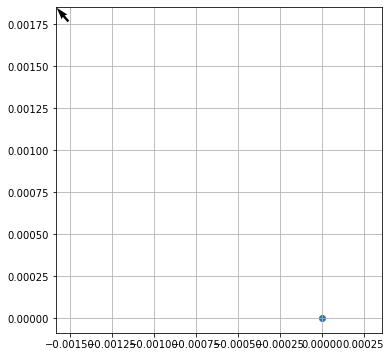

In [6]:
plotConditions(dataDFSph2,5)

carDF = sphDF2CarDF(dataDFSph2)
# print (carDF.head(5))
figA = plt.figure(figsize = (6,6))
plt.quiver(carDF.x,carDF.y,carDF.vx, carDF.vy)
plt.scatter(0,0)
# plt.axes([min(carDF.x)*0.9,max(carDF.x)*1.1,])
plt.grid()
plt.axis('square')
plt.show()

In [11]:
def Bfield(x,y,z):
    '''
    Returns cartesian components of the B-field measured in MeV^2 at location x,y,z.
    
    x,y,z must be in cartesian coordinates measured in Au
    '''
    assert x**2 + y**2 > 0, 'Bfield function, both x & y zero simultaneously'
#  T = 1 kg⋅s−2⋅A−1 = N s / C m = kg / C s 
#    = [mass] / [charge] [time]

    # 3.3 in nT
    BrSun     = 0
#     BthetaSun = 3.3e-9/np.sqrt(2) * 1/rFunction(x,y,z)
    BthetaSun = 0
    BphiSun   = 3.3e-9/np.sqrt(2) * 1/rFunction(x,y,z) 
#     BphiSun = 0

    # Spherical unit vector decompositions
    # Schematically, we decompose rhat = Axhat + Byhat + Czhat and read off the ABC from wiki
    # The arguments of the ABCs are the cartesian location where we are evaluating the B field
    def A(x,y,z):
        return x/np.sqrt(x**2 +y**2 +z**2)

    def B(x,y,z):
        return y/np.sqrt(x**2 +y**2 +z**2)

    def C(x,y,z):
        return z/np.sqrt(x**2 +y**2 +z**2)

    def D(x,y,z):
        return x*z / (np.sqrt(x**2 +y**2 +z**2) * np.sqrt(x**2+y**2))

    def E(x,y,z):
        return y*z / (np.sqrt(x**2 +y**2 +z**2) * np.sqrt(x**2+y**2))
        
    def F(x,y,z): 
        return -(x**2 + y**2) / (np.sqrt(x**2 +y**2 +z**2) * np.sqrt(x**2+y**2)) 

    def G(x,y,z):
        return -y / np.sqrt(x**2 + y**2)

    def H(x,y,z):
        return x / np.sqrt(x**2 + y**2)

    def I(x,y,z):
        return 0

    BxSun = BrSun * A(x,y,z) + BthetaSun * D(x,y,z) + BphiSun * G(x,y,z)
    BySun = BrSun * B(x,y,z) + BthetaSun * E(x,y,z) + BphiSun * H(x,y,z)
    BzSun = BrSun * C(x,y,z) + BthetaSun * F(x,y,z) + BphiSun * I(x,y,z)

    # Earth Magnetic field is 25-65 nanoTesla at the Surface
    mu0 = 4e-7*np.pi
    rOrbit = 1
    
    BxEarth = 0
    ByEarth = 0
#     BzEarth = 45e-6/(rFunction(x,y,z)-rOrbit)
    BzEarth = 0
    
    BxSun = 0
    BySun = 0
    BzSun = 1.5e-14 # 1.5e-14 seems to work well
    

    BxTotal, ByTotal, BzTotal = BxSun+BxEarth, BySun+ByEarth, BzSun+BzEarth
    return (tesla2MeV2(BxTotal), tesla2MeV2(ByTotal), tesla2MeV2(BzTotal))



print ('Complete')

Complete


In [12]:
masterDFColumns = ['ConNo','E','Beta1','Beta2']
masterDF = pd.DataFrame(columns = masterDFColumns)
numE = 50
eRange = np.linspace(0.0008,32,numE)
q = 0.3
c = 1
dt = 1e-2

for row in range(0,len(dataDFSph2)):
    ConNo = dataDFSph2.ConNo[row]
    for E in eRange:
        ICSph = dataDFSph2.loc[row]['r':'vPhi']
        BetaOutput = (computeBeta(ICSph,q,E,dt,True))
        hit = 'Y'
        
        if BetaOutput == 'F':
#             print ('Skip calculation for {0} MeV'.format(E))
            hit = 'N'
            continue
            
        beta1 = BetaOutput[0]
        beta2 = BetaOutput[1]
                 
        appendThis = ({'ConNo':ConNo,'E':E,'Beta1':beta1,'Beta2':beta2,'Hit':hit})
        masterDF = masterDF.append(appendThis,ignore_index=True)
#         i+=1
# hitDF1 = getHitDF(testDF1,energy,plane,q,dt,cartesian = True)
# masterDF = masterDF.append(hitDF1,ignore_index = True).drop_duplicates().reset_index(drop=True)

print (masterDF.head(4))

print ('Complete')

   ConNo         E     Beta1     Beta2 Hit
0    0.0  0.653845 -0.152992  0.152992   Y
1    0.0  1.306890 -0.075779  0.075779   Y
2    0.0  1.959935 -0.050530  0.050530   Y
3    0.0  2.612980 -0.037901  0.037901   Y
Complete


In [13]:
fig = px.histogram(masterDF, x='Beta2',color = 'E')
print ('{0}/{1} hits'.format(len(masterDF),len(dataDFSph2)*numE))
# fig.add_vline(x=10*np.pi/180, line_color = 'red')
fig.add_vline(x=20*np.pi/180, line_color = 'orange')
# fig.add_vline(x=30*np.pi/180, line_color = 'yellow')
# fig.add_vline(x=40*np.pi/180, line_color = 'green')
fig.show()
print ('x-axis in rad')

49/50 hits


x-axis in rad


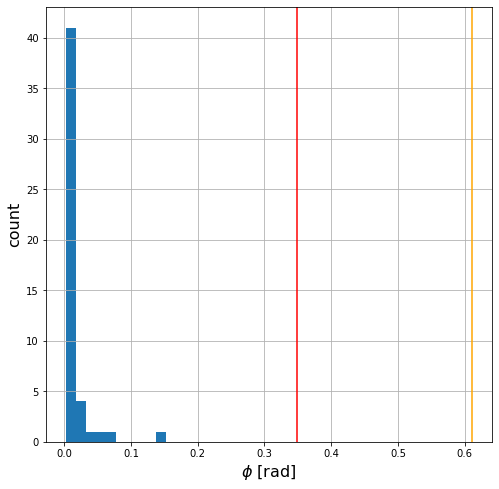

In [14]:
BetaArray = (masterDF.Beta2)#*180/np.pi
figB = plt.figure(figsize = (8,8))
plt.xlabel(r'$\phi$ [rad]',size = 16)
plt.ylabel('count',size = 16)
plt.hist(BetaArray)
plt.axvline(x=(20*np.pi/180),c = 'red')
plt.axvline(x=(35*np.pi/180),c = 'orange')
plt.grid()

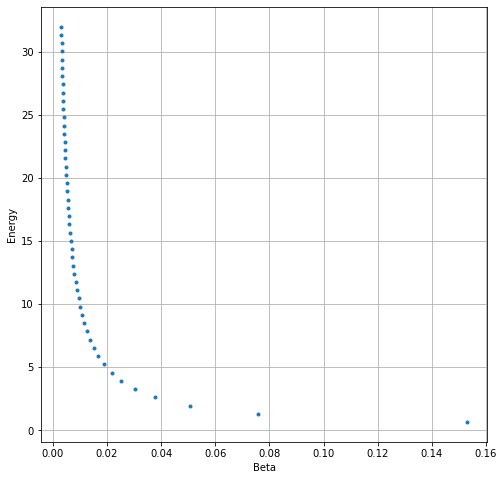

In [15]:
figy = plt.figure(figsize = (8,8))
plt.plot(masterDF.Beta2,masterDF.E,'.')
plt.xlabel('Beta')
plt.ylabel('Energy')
plt.grid()
plt.show()

## Single Energy Testing

In [16]:
def Bfield(x,y,z):
    '''
    Returns cartesian components of the B-field measured in MeV^2 at location x,y,z.
    
    x,y,z must be in cartesian coordinates measured in Au
    '''
    assert x**2 + y**2 > 0, 'Bfield function, both x & y zero simultaneously'
#  T = 1 kg⋅s−2⋅A−1 = N s / C m = kg / C s 
#    = [mass] / [charge] [time]

    # 3.3 in nT
    BrSun     = 0
#     BthetaSun = 3.3e-9/np.sqrt(2) * 1/rFunction(x,y,z)
    BthetaSun = 0
    BphiSun   = 3.3e-9/np.sqrt(2) * 1/rFunction(x,y,z)
#     BphiSun = 0

    # Spherical unit vector decompositions
    # Schematically, we decompose rhat = Axhat + Byhat + Czhat and read off the ABC from wiki
    # The arguments of the ABCs are the cartesian location where we are evaluating the B field
    def A(x,y,z):
        return x/np.sqrt(x**2 +y**2 +z**2)

    def B(x,y,z):
        return y/np.sqrt(x**2 +y**2 +z**2)

    def C(x,y,z):
        return z/np.sqrt(x**2 +y**2 +z**2)

    def D(x,y,z):
        return x*z / (np.sqrt(x**2 +y**2 +z**2) * np.sqrt(x**2+y**2))

    def E(x,y,z):
        return y*z / (np.sqrt(x**2 +y**2 +z**2) * np.sqrt(x**2+y**2))
        
    def F(x,y,z): 
        return -(x**2 + y**2) / (np.sqrt(x**2 +y**2 +z**2) * np.sqrt(x**2+y**2)) 

    def G(x,y,z):
        return -y / np.sqrt(x**2 + y**2)

    def H(x,y,z):
        return x / np.sqrt(x**2 + y**2)

    def I(x,y,z):
        return 0

#     BxSun = BrSun * A(x,y,z) + BthetaSun * D(x,y,z) + BphiSun * G(x,y,z)
#     BySun = BrSun * B(x,y,z) + BthetaSun * E(x,y,z) + BphiSun * H(x,y,z)
#     BzSun = BrSun * C(x,y,z) + BthetaSun * F(x,y,z) + BphiSun * I(x,y,z)

    # Earth Magnetic field is 25-65 nanoTesla at the Surface
    mu0 = 4e-7*np.pi
    rOrbit = 1
    
    BxEarth = 0
    ByEarth = 0
#     BzEarth = 45e-6/(rFunction(x,y,z)-rOrbit)
    BzEarth = 0
    
    BxSun = 0
    BySun = 0
    BzSun = 1e-13

    BxTotal, ByTotal, BzTotal = BxSun+BxEarth, BySun+ByEarth, BzSun+BzEarth
    return (tesla2MeV2(BxTotal), tesla2MeV2(ByTotal), tesla2MeV2(BzTotal))
#     return ((BxTotal), (ByTotal), (BzTotal))

In [23]:
def trajectorySolver(initialConditions, q_e, E_MeV, dt1):
    '''
    xi = gB-L/q_e

    Inputs:
        initialConditions: array of [r0,v0] in cartesian coordinates
                           in units of au and "c" respectively
        q : the electric charge in units of "e"
        m : the mass/energy of the particle in MeV.
        dt: the time increment between each step in Au/c

    Returns:
        trajectory: the 3-vector (x,y,z), the position of the neutrino at each step
        velocity  : the 3-vector (vX,vY,vZ), the velocity of the neutrino at each step
    '''
#     print ('trajSolver|initialConditions:',initialConditions)
    r0 = initialConditions[0:3] # In units of au
#     print ('trajSolver|r0',r0)
    v0 = initialConditions[3:6] # In units of c
#     assert ((r0[0] != 0) or (r0[1] !=0)), "X and Y initial positions cannot be simultaneously zero. See Jacobian tranformation in the definition of Bfield."
#     assert ((r0[0] != 0) and (r0[1] !=0)), "X and Y initial positions cannot be simultaneously zero. See Jacobian tranformation in the definition of Bfield."

#     q_coulombs  = q_e * 1.60217662e-19  # units of Coulombs
#     m_kg  = E_MeV * 1.78e-30 * (2e-3)**2 # units of kilograms
#     q_by_E  = q_coulombs/m_kg
    q_by_E = q_e/E_MeV
#     print ('q/E',q_by_E)

    # pos = np.array([r0[0],r0[1],r0[2]])
    # vel = np.array([v0[0],v0[1],v0[2]]) 
    pos = np.asarray(r0)
#     print ('trajSolver|pos',pos)
    vel = np.asarray(v0)
#     print ('trajSolver|vel',vel)
#     acc = q_by_E * acceleration_normed(vel, pos)
#     print ('x,y,z,vx,vy,vz|BEFORE',xPoints,yPoints,zPoints,vxPoints,vyPoints,vzPoints)
    xPoints=[] # record of x-values
    yPoints=[] # record of y-values
    zPoints=[] # record of z-values
    vxPoints=[] # record of x-velocities
    vyPoints=[] # record of y-velocities
    vzPoints=[] # record of z-velocities
#     print ('x,y,z,vx,vy,vz|AFTER',xPoints,yPoints,zPoints,vxPoints,vyPoints,vzPoints)

    
    
    def dvdt(pos,vel,dt,q_by_E):
        x,y,z = pos[0],pos[1],pos[2]
        return q_by_E*np.cross(vel,Bfield(x,y,z))

    def drdt(pos,vel,dt,q_by_E):
        return vel
    
    dt = sec2geVInv(auOverc2min(dt1)*60)*10**-3
    
    # Initialize half values
    x_half = pos[0] + 0.5*dt1*drdt(pos,vel,dt1,q_by_E)[0]
    y_half = pos[1] + 0.5*dt1*drdt(pos,vel,dt1,q_by_E)[1]
    z_half = pos[2] + 0.5*dt1*drdt(pos,vel,dt1,q_by_E)[2]
    
    vx_half = vel[0] + 0.5*dt*dvdt(pos,vel,dt,q_by_E)[0]
    vy_half = vel[1] + 0.5*dt*dvdt(pos,vel,dt,q_by_E)[1]
    vz_half = vel[2] + 0.5*dt*dvdt(pos,vel,dt,q_by_E)[2]

    posHalf = [x_half,y_half,z_half]
    velHalf = [vx_half,vy_half,vz_half]

    
#     print ('trajSolver,above distance',pos)
    distance = np.sqrt(pos[0]**2 + pos[1]**2 + pos[2]**2)
#     print ('trajSolver|distance:',distance)
    assert distance < 1, 'trajectorySolver: Distance larger than 1'
    
    earthDist = 1.0
#     print ('trajSolver|StartLoop|IC',initialConditions)
    
    print ('Initial Pos   : {0}'.format(pos))
    print ('Initial Vel   : {0}'.format(vel))
    print ('Initial 1/2Pos: {0}'.format(posHalf))
    print ('Initial 1/2Vel: {0}'.format(velHalf))

    i = 0
    while distance < earthDist:
#     for i in range(0,4):
#         print ('trajSolver|EndLoop|FLOAT',initialConditions)
        # Append Points
        xPoints.append(pos[0])
        yPoints.append(pos[1])
        zPoints.append(pos[2])
#         print ('x,y,z',xPoints[-1],yPoints[-1],zPoints[-1])

        ######### Normalize Velocity #########
#         velPrecision = 1e-5
#         velNorm = np.sqrt(vel[0]**2 + vel[1]**2 + vel[2]**2)
#         vel[0] = vel[0]/velNorm
#         vel[1] = vel[1]/velNorm
#         vel[2] = vel[2]/velNorm
#         if (np.abs(1-velNorm) >= velPrecision ):
#             print ('Velocity normalization outside precision {0}'.format(velPrecision))
#         print ('VelNorm', velNorm)

        vxPoints.append(vel[0])
        vyPoints.append(vel[1])
        vzPoints.append(vel[2])
        
        # We put the distance update specifically here so that 
        # we record the last distance that is larger than 1
        newDistance = np.sqrt(pos[0]**2 + pos[1]**2 + pos[2]**2)
        assert newDistance>=distance, 'Step {0}, Particle never hits Earth.'.format(i)
#         print ('distance',distance)
        distance = newDistance
        # Leapfrog
        # I actually don't know which of these should come first...
        #     Do we need to update the half positions first    

        pos[0] += dt1*drdt(posHalf,velHalf,dt1,q_by_E)[0]
        pos[1] += dt1*drdt(posHalf,velHalf,dt1,q_by_E)[1]
        pos[2] += dt1*drdt(posHalf,velHalf,dt1,q_by_E)[2]
        vel[0] += dt*dvdt(posHalf,velHalf,dt,q_by_E)[0]
        vel[1] += dt*dvdt(posHalf,velHalf,dt,q_by_E)[1]
        vel[2] += dt*dvdt(posHalf,velHalf,dt,q_by_E)[2] 
        
        posHalf[0] += dt1*drdt(pos,vel,dt1,q_by_E)[0]
        posHalf[1] += dt1*drdt(pos,vel,dt1,q_by_E)[1]
        posHalf[2] += dt1*drdt(pos,vel,dt1,q_by_E)[2]
        velHalf[0] += dt*dvdt(pos,vel,dt,q_by_E)[0]
        velHalf[1] += dt*dvdt(pos,vel,dt,q_by_E)[1]
        velHalf[2] += dt*dvdt(pos,vel,dt,q_by_E)[2]
        
        i += 1
        print ('\n-----------------')
        print ('i     :', i)
        print ('pos   : {0}'.format(pos))
        print ('vel   : {0}'.format(vel))
        print ('1/2pos: {0}'.format(posHalf))
        print ('1/2vel: {0}'.format(velHalf))

        
#         print ('end single dt')
#     print ('pos,vel|END',pos,vel)
#     print ('x,y,z,vx,vy,vz|ENDLOOP|Start',xPoints[0],yPoints[0],zPoints[0],vxPoints[0],vyPoints[0],vzPoints[0])
#     print ('x,y,z,vx,vy,vz|ENDLOOP|End',xPoints[-1],yPoints[-1],zPoints[-1],vxPoints[-1],vyPoints[-1],vzPoints[-1])
    trajectory = [xPoints,yPoints,zPoints]
    velocity   = [vxPoints,vyPoints,vzPoints]
    trajTime = auOverc2min(len(trajectory[0])*dt)
#     assert(trajTime > auOverc2min(lightTime)), "Trajectory Time: {0} min. Neutrino is moving faster than light.".format(trajTime)
#     if (trajTime < auOverc2min(lightTime)):
#         print ('WARNING: neutrino moving faster than light. Change dt')
#         print ('Current dt: ',dt)
#     if (len(trajectory[0]) <= 2):
#         print ('WARNING: only two data points in the trajectory. Decrease dt')
#         print ('Current dt: ',dt)
    return (trajectory,velocity)

print ('Complete')

Complete


In [20]:
print (sec2geVInv(auOverc2min(1)*60)*10**-3)
print (rHalf)
print (tesla2MeV2(1))

7.5848727168e+23
0.002325235
5.848e-11


Initial Pos   : [0.00232524 0.         0.        ]
Initial Vel   : [1. 0. 0.]
Initial 1/2Pos: [0.007325235, 0.0, 0.0]
Initial 1/2Vel: [1.0, -0.006653450347176961, 0.0]

-----------------
i     : 1
pos   : [ 1.23252350e-02 -6.65345035e-05  0.00000000e+00]
vel   : [ 0.99991146 -0.0133069   0.        ]
1/2pos: [0.017324349631969552, -0.00013306900694353923, 0.0]
1/2vel: [0.9998229263939106, -0.019959172891084967, 0.0]

-----------------
i     : 2
pos   : [ 0.02232346 -0.00026613  0.        ]
vel   : [ 0.99964587 -0.02661145  0.        ]
1/2pos: [0.027320808316623077, -0.0003991834578216994, 0.0]
1/2vel: [0.9994688105367937, -0.03326136119227459, 0.0]

-----------------
i     : 3
pos   : [ 0.03231815 -0.00059874  0.        ]
vel   : [ 0.99920326 -0.03991128  0.        ]
1/2pos: [0.037312840944973155, -0.0007982962307890311, 0.0]
1/2vel: [0.9989377151332213, -0.04655765978429445, 0.0]

-----------------
i     : 4
pos   : [ 0.04230753 -0.00106432  0.        ]
vel   : [ 0.99858372 -0.05320404

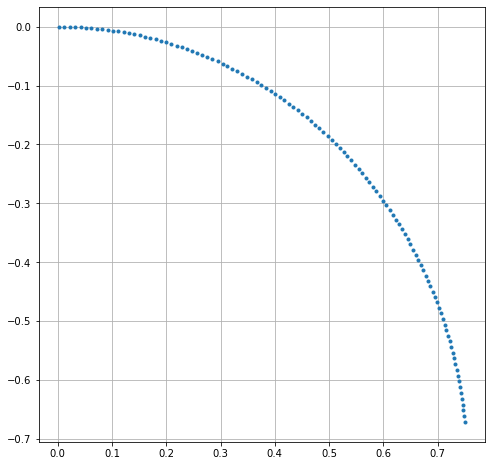

In [24]:
q = 0.3
E = 1
dt = 1e-2

sphCon = [rHalf,np.pi/2,0,1,0,0]
carCon = conditionSph2Car(sphCon)
output = trajectorySolver(carCon,q,E,dt)
phia,phib = phiFunc(output)
print ('phi1: {0} rad \nphi2: {1} rad'.format(phia/np.pi,phib/np.pi))
print ('estimate: {0} rad'.format(angleEstimate(1e-13,1)))
pos = output[0]
x,y,z = pos[0],pos[1],pos[2]

fig4 = plt.figure(figsize = (8,8))
plt.plot(x,y,'.')
# plt.axis('square')
plt.grid()

pos = output[0]
x,y,z = pos[0],pos[1],pos[2]
# print ('rHalf: {0}'.format(rHalf))
# print ('r0: ({0},{1},{2})'.format(x[0],y[0],z[0]))
# print ('r1: ({0},{1},{2})'.format(x[1],y[1],z[1]))

### Magnetic Field Plots

In [85]:
num       = 50
theta     = np.pi/2
phi       = 0
rList     = np.linspace(rHalf,0.9999999,num)
thetaList = np.full(len(rList),theta)
phiList   = np.full(len(rList),phi)

rList     = [rList,thetaList,phiList]
points    = np.transpose(rList)

xList,yList,zList = [],[],[]
for p in points:
    xList.append(sph2Cartesian(p)[0])
    yList.append(sph2Cartesian(p)[1])
    zList.append(sph2Cartesian(p)[2])

carPoints = np.transpose([xList,yList,zList])
# print (carPoints)

BfieldFunc = np.vectorize(Bfield)
BVect = BfieldFunc(xList,yList,zList)
Bx = BVect[0]
By = BVect[1]
Bz = BVect[2]


print ('Complete')

Complete


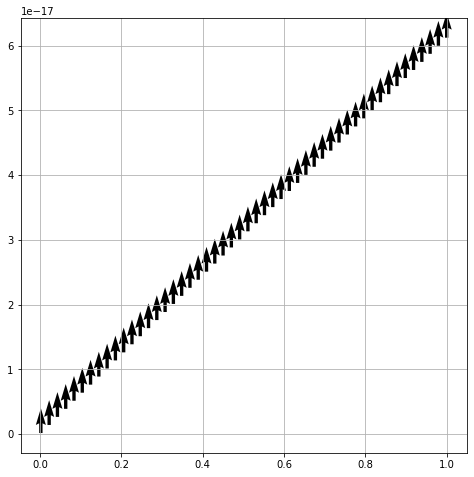

In [422]:
fige = plt.figure(figsize = (8,8))
plt.quiver(xList,zList,Bx,Bz)
plt.grid()
plt.show()

In [ ]:
fig1 = go.Figure(data=go.Cone(
x=xList, 
y=yList, 
z=zList, 
u=Bx, 
v=By, 
w=Bz,
sizemode = 'absolute',
sizeref = 0.1,
))

# Add the location of the sun
# fig1.add_trace(
# go.Scatter3d(
#     x=[0],
#     y=[0],
#     z=[0],
#     mode = 'markers',
#     marker = dict(
#         size = 6,
#         color = 'orange')
#             )
#         )
fig1.show()

# Field Strength Estimation

In [3]:
def epsilonFunc(BTesla,EMeV):
    c = 1
    q = 0.3
    
    BMeV2 = tesla2MeV2(BTesla)
    rSync = EMeV / (c*q*BMeV2) # In MeV^-1
    rOrbit = km2geVInv(au2km(1))/1000 # In MeV^-1
    ep = rOrbit/rSync
#     if 0<=ep.any()<=2:
#     print ('From the derivation, we have ...ArcCos(1-1/2 ep^2)')
#     print ('Epsilon outside physical range')
    return ep

    
def angleEstimate(BTesla,EMeV):
    c = 1
    e = 0.3
    
    omegaS = e*tesla2MeV2(BTesla)/(EMeV) # In MeV
    omegaO = sec2geVInv(2*np.pi/(365*24*3600))/1000 # In MeV
    
    
    ep = epsilonFunc(BTesla,EMeV)
    
    # alpha is the rHat direction
    # beta is the direction of the trajectory
    tStar = np.arccos(1-0.5*ep**2)/omegaS    
    alpha = np.arctan(1/np.tan(np.arccos(1-0.5*ep**2)))
    beta = np.arctan(np.sin(np.arccos(1-0.5*ep**2)) / (1/2*ep**2) )    
    
    phi = -(alpha-beta)
    phiDeg = phi*180/np.pi
#     return (phiDeg%90)
    return (phi)

epsilonFunc = np.vectorize(epsilonFunc)
angleEstimate = np.vectorize(angleEstimate)


def BFunc(EMeV,epsilon):
    '''
    Given epsilon = R_orbit/R_Synch ~ B/E, this function computes
    the value of B for a given E and epsilon.
    '''
    auMeVInv = km2geVInv(au2km(1))/1000 #in MeV^-1
    q = 0.3
    c = 1
    slope = epsilon / (auMeVInv*q*c)
    return slope*MeV22tesla(EMeV)
#     return epsilon * 0

print ('Complete')

Complete


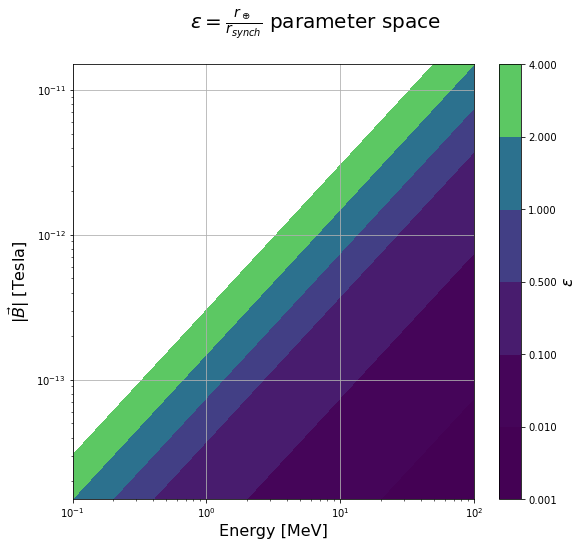

In [4]:
eMin = 0.1
eMax = 100
ep = 2
nPoints = 100
EList = np.logspace(np.log10(eMin),np.log10(eMax),nPoints)
BList = np.logspace(np.log10(BFunc(eMin,ep)),np.log10(BFunc(eMax,ep)),nPoints)
# BList = np.logspace(-12,-8,nPoints)
# BList = np.linspace(1e-17,1e-14,100)

XX,YY = np.meshgrid(BList,EList)
ZZ = epsilonFunc(XX,YY)
fig = plt.figure(figsize = (9,8))
# plt.contourf(np.log10(YY),np.log10(XX),ZZ,cmap = 'viridis')
plt.contourf((YY),(XX),ZZ,[0.001,0.01,0.1,0.5,1,2,4],cmap = 'viridis')
# plt.contourf((YY),(XX),ZZ,cmap = 'viridis')

plt.suptitle(r'$\varepsilon = \frac{r_\oplus}{r_{synch}}$ parameter space', size = 20)
plt.ylabel(r'$|\vec{B}|$ [Tesla]',size = 16)
plt.xlabel('Energy [MeV]',size = 16)
plt.xscale('log')
plt.yscale('log')
plt.colorbar().set_label(r'$\varepsilon$',size = 16)
plt.grid()
# plt.plot(BList,phiList)


<ipython-input-3-6c80aca07b3f>:27: RuntimeWarning:

invalid value encountered in arccos

<ipython-input-3-6c80aca07b3f>:28: RuntimeWarning:

invalid value encountered in arccos

<ipython-input-3-6c80aca07b3f>:29: RuntimeWarning:

invalid value encountered in arccos



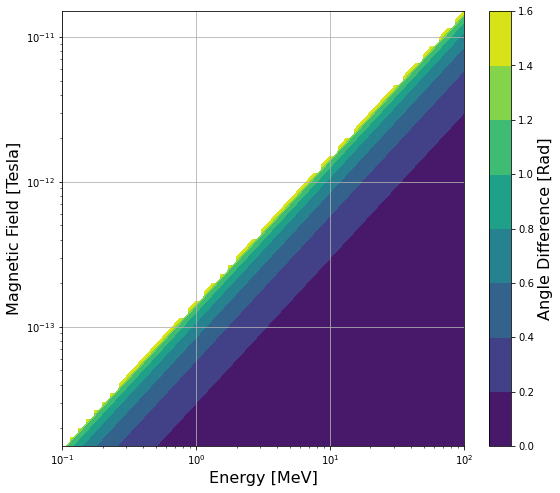

In [5]:
nPoints = 100
eMin = 0.1
eMax = 100
ep = 2
# EList = np.linspace(eMin,eMax,nPoints)
# BList = np.linspace((BFunc(eMin,ep)),BFunc(eMax,ep),nPoints)

BList = np.logspace(np.log10(BFunc(eMin,ep)),np.log10(BFunc(eMax,ep)),nPoints)
EList = np.logspace(np.log10(eMin),np.log10(eMax),nPoints)
XX,YY = np.meshgrid(BList,EList)

fig3 = plt.figure(figsize = (9,8))
angles = angleEstimate(XX,YY)
# angles = phi2(XX,YY)
# angles = phiFunc(XX,YY)[0]
# angles = phiFunc(XX,YY)[1]
plt.contourf((YY),(XX), angles) # plot B vertically and E horizontally
plt.ylabel('Magnetic Field [Tesla]', size = 16)
plt.xlabel('Energy [MeV]',size = 16)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.colorbar().set_label(r'Angle Difference [Rad]',size = 16)


# Importing the Neutrino Spectra

To make the interpolation of $\frac{d\phi}{dE}$ easier, we choose a minimim and maximum energy just beyond the extent of the spectrum. We choose
    
    eMin = 0.0008 MeV
    eMax = 32 MeV
    
Using the geometic argument that $\varepsilon \leq 2$, this corresponds to a maximal magnetic field value of $B \leq 1.2\times10^{-16}$ tesla.

We import the normalized probablity distribution for each spectrum. To obtain the flux, multiply by the total flux factor for each species.

The first set of flux factors is given in Table 2 of [this paper](https://iopscience.iop.org/article/10.1086/428929/pdf) and should match figure 2.

The second of flux factors is given in table 2 of [this paper](https://www.nature.com/articles/s41586-018-0624-y.pdf) and should match figure 1. (Borexino)

The third set of flux factors come from table 1 of [this review paper](https://arxiv.org/abs/2107.08613) (2021). This I believe is the most recent flux data

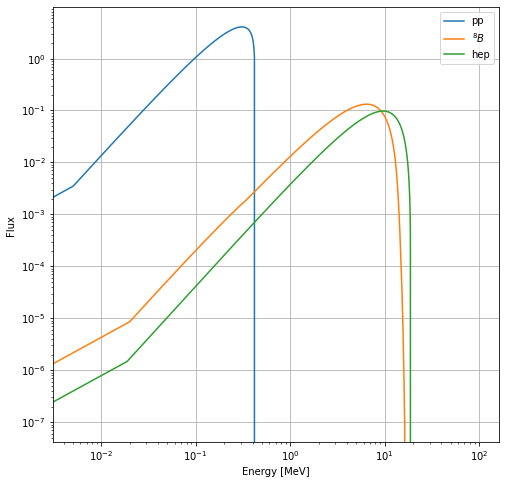

In [70]:
ppSpectra = pd.read_csv('Data/ppSpectrum2.csv')
ppE = ppSpectra.q_MeV
ppS = ppSpectra.spectrum

# b8Spectra = pd.read_csv('Data/ppSpectrum5.csv')
b8Spectra = pd.read_csv('Data/b8Spectrum2.csv')
b8E = b8Spectra.q_MeV
b8S = b8Spectra.spectrum

hepSpectra = pd.read_csv('Data/hepSpectrum2.csv')
hepE = hepSpectra.q_MeV
hepS = hepSpectra.spectrum

# Normalizations from astro-ph/0412440 (2005)
# ppFF  = 5.99E10
# b8FF  = 5.69e6
# hepFF = 7.93e3

# Normalizations from https://www.nature.com/articles/s41586-018-0624-y (2018)
# ppFF  = 6.1e10
# b8FF  = 5.68e6
# hepFF = 2.2e5

# Normalizations from table 1 of 2107.08613 (2021) Solar (Global) subject to luminoscity constraint
# ppFF  = 5.971e10
# b8FF  = 5.16e6
# hepFF = 19e3

ppFF  = 1
b8FF  = 1
hepFF = 1


figS = plt.figure(figsize = (8,8))
plt.plot(ppE,np.multiply(ppS,ppFF),label = 'pp')
plt.plot(b8E,np.multiply(b8S,b8FF),label = '$^8B$')
plt.plot(hepE,np.multiply(hepS,hepFF),label = 'hep')

# Plot bounds to match fig 2 
# plt.xlim([0.9E-1,30])
# plt.ylim([0.9e1,5e11])

plt.legend(loc = 'upper right')
plt.grid()
plt.xlabel('Energy [MeV]')
plt.ylabel('Flux ')
plt.xscale('log')
plt.yscale('log')


## "L1" Normalization Check

An "L1" normalization just means $\int \ [...] \ dx = 1$

Here, we ensure that i) the data is properly normalized and ii) the `L1Norm` function works correctly.

pp normalization :  -176773.79415220246
b8 normalization :  130.44571749349797
hep normalization:  -6.4445502892653135
-------------
pp Raw Data/ L1 Data:  0.9998820719999999
b8 Raw Data/ L1 Data:  0.0009948455193525259
hep Raw Data/ L1 Data:  0.9998003009501399


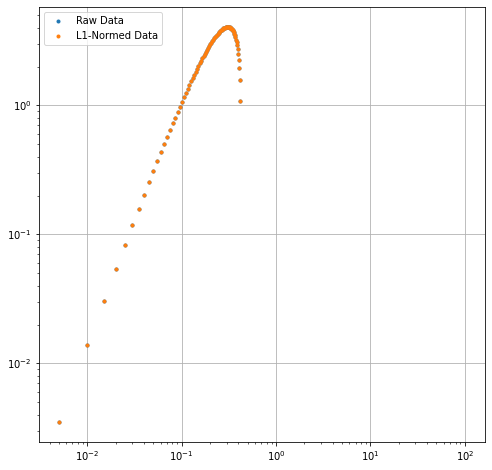

In [14]:
ppInt  = integrate.simps(y=ppS,x=ppE)
b8Int  = integrate.simps(y=b8S, x=b8E)
hepInt = integrate.simps(y=hepS,x=hepE)

ppNormed  = L1Norm(ppS,ppSpectra.step_MeV[0])
b8Normed  = L1Norm(b8S,b8Spectra.step_MeV[0])
hepNormed = L1Norm(hepS,hepSpectra.step_MeV[0])

print('pp normalization : ',ppInt)
print('b8 normalization : ',b8Int)
print('hep normalization: ',hepInt)
print ('-------------')
print('pp Raw Data/ L1 Data: ',ppS.iloc[3]/ppNormed[3])
print('b8 Raw Data/ L1 Data: ',b8S.iloc[3]/b8Normed[3])
print('hep Raw Data/ L1 Data: ',hepS.iloc[3]/hepNormed[3])



figNorm = plt.figure(figsize = (8,8))
ppNormed = L1Norm(ppS,ppSpectra.step_MeV[0])
plt.plot(ppE,ppS,'.',label = 'Raw Data')
plt.plot(ppE,ppNormed,'.', label = 'L1-Normed Data')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc = 'upper left')
plt.grid()

## Min/Max Check

In [5]:
print (min(ppE),min(b8E),min(hepE))
print (max(ppE),max(b8E),max(hepE))

0.00504 0.01 0.01878
0.42341000000000006 16.56 18.784000000000002


## Interpolations Comparisons (Not Used)

We interpolate the data and determine how many interpolation points are required to adquately capture the spectra.

ValueError: A value in x_new is below the interpolation range.

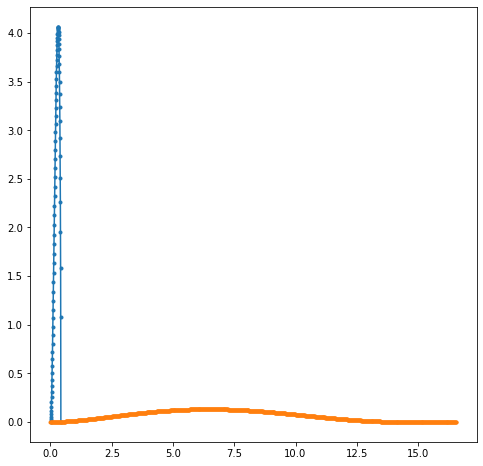

In [60]:
ppFunc  = interpolate.interp1d(ppE,ppS)
b8Func  = interpolate.interp1d(b8E,b8S)
hepFunc = interpolate.interp1d(hepE,hepS)

interpNum = 7000
eRange = np.linspace(min(ppE),max(ppE),interpNum)

figInterp = plt.figure(figsize = (8,8))
plt.plot(eRange,ppFunc(eRange),color = 'C0',label = 'pp interp')
plt.plot(ppE,ppS,'.',color = 'C0', label = 'pp data')
plt.plot(eRange,b8Func(eRange),color = 'C1', label = 'B8 interp')
plt.plot(b8E,b8S,'.',color = 'C1',label = 'B8 data')
plt.plot(eRange,hepFunc(eRange),color = 'C2',label = 'hep interp')
plt.plot(hepE,hepS,'.',color = 'C2',label = 'hep data')
plt.title('{0} Interpolation points'.format(interpNum))
plt.legend(loc = 'upper left')
plt.xscale('log')
plt.yscale('log')
plt.grid()

## Matching the energy spacing for each spectrum (Not Used)

In [48]:
ppSpacing  = ppSpectra.step_MeV[0]
hepSpacing = hepSpectra.step_MeV[0]
b8Spacing  = b8Spectra.step_MeV[0]

ppRange  = np.arange(min(ppE),max(ppE),ppSpacing)
hepRange = np.arange(min(hepE),max(hepE),hepSpacing)
b8Range  = np.arange(min(b8E),max(b8E),b8Spacing)

print (len(ppRange),len(hepRange),len(b8Range))

84 1000 828


# Getting $\phi(E)$ and $\frac{d\phi}{dE}$

## Constructing $\phi \equiv \phi(E)$

We make a single trajectory with nominal values

In [15]:
IICDF = makeInitialConditions(1)
radialVelocity = True

columns = np.asarray(IICDF.columns)
IICDF2 = pd.DataFrame(columns=columns)
v1 = [1,0,0]

# margin = 1e-7
margin = 1/2
# deltaTheta = (margin*(np.pi/2))
deltaTheta = 0
deltaPhi = margin*2*np.pi/2
# deltaPhi = 0
 

for row in IICDF.ConNo:
#     phi = float(minLossCondition.phi)
    phi = np.pi/2
#     theta = float(minLossCondition.theta)
    theta = np.pi/2
    
    randTheta = np.random.uniform( (theta-deltaTheta), (theta+deltaTheta) )
    randPhi   = np.random.uniform( (phi-deltaPhi), (phi+deltaPhi) )
    p1 = [rHalf,randTheta,randPhi]

    if radialVelocity:
        r      = p1[0]
        theta  = p1[1]
        phi    = p1[2]
        vr     = v1[0]
        vtheta = v1[1]
        vphi   = v1[2]
        
    else: 
        r      = p1[0]
        theta  = p1[1]
        phi    = p1[2]
        vtheta = 0
        vphi   = np.random.uniform(-1,1)
        vr     = np.sqrt(1-vphi**2)


    appendThis = ({'ConNo':row,'r':r,'theta':theta,'phi':phi,'vr':vr,'vTheta':vtheta,'vPhi':vphi})
#     appendThis = ({'r':r,'theta':theta,'phi':phi,'vr':vr,'vTheta':vtheta,'vPhi':vphi})

    IICDF2 = IICDF2.append(appendThis,ignore_index=True)
    
# dataDFSph2 = computeLossAndBeta(dataDFSph2,q,m,dt)
print (IICDF2.head(5))
print ('Complete')

   ConNo         r     theta       phi   vr  vTheta  vPhi   L  cosBeta
0    0.0  0.002325  1.570796  2.121712  1.0     0.0   0.0 NaN      NaN
Complete


We intentionally scan over energies that extend slightly beyond the limits of any spectra. This is to ensure that dphi/dE is defined over the entire domain of each spectrum.

Further, we want to choose $E$ such that $\phi(E) \rightarrow [0,\pi/2]$ 

Arbitrarily, we choose

    eMin = 0.0008 MeV
    eMax = 32 MeV

To guarentee that all energies intersect Earth, we use the geometric argument that $\varepsilon \leq 2$, which corresponds to $|B| \sim 1.2 \times 10^{-16}$ Tesla.

Make an interpolation using `numE` data points.

In [16]:
masterDFColumns = ['ConNo','E','Beta1','Beta2']
masterDF = pd.DataFrame(columns = masterDFColumns)


numE = 250
# eMin is chosen to be below the smallest energy in any spectrum
# eMax is chosen to be above the largest energy in any spectrum
interpEMIN = 0.0001
interpEMAX = 50
eRange = np.logspace(np.log10(interpEMIN),np.log10(interpEMAX),numE)


q = 0.3
c = 1
dt = 1e-2

for row in range(0,len(IICDF2)):
    ConNo = IICDF2.ConNo[row]
    for E in eRange:
        ICSph = IICDF2.loc[row]['r':'vPhi']
        BetaOutput = (computeBeta(ICSph,q,E,dt,True))
        hit = 'Y'
        
        if BetaOutput == 'F':
#             print ('Skip calculation for {0} MeV'.format(E))
            hit = 'N'
            continue
            
        beta1 = BetaOutput[0]
        beta2 = BetaOutput[1]
         
        appendThis = ({'ConNo':ConNo,'E':E,'Beta1':beta1,'Beta2':beta2,'Hit':hit})
        masterDF = masterDF.append(appendThis,ignore_index=True)
        
print ('Complete')

Complete


250/250 hits


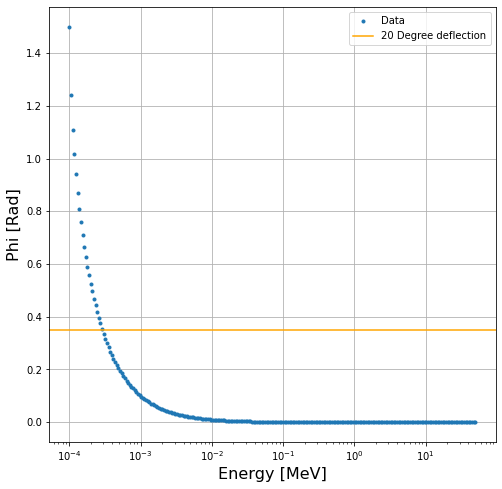

phiMax:  1.4993713430141709 ,  1.5707963267948966
phiMin:  1.9806776819605796e-06


In [17]:
print ('{0}/{1} hits'.format(len(masterDF.E), numE))
figy = plt.figure(figsize = (8,8))
plt.plot(masterDF.E,masterDF.Beta2,'.',label = 'Data')
plt.xlabel('Energy [MeV]', size = 16)
plt.ylabel('Phi [Rad]', size = 16)
plt.axhline(y=np.pi*20/180,color = 'orange', label = '20 Degree deflection')
plt.xscale('log')
plt.yscale('linear')
plt.legend(loc = 'upper right')
plt.grid()
plt.show()

print ('phiMax: ',max(masterDF.Beta2),', ',np.pi/2)
print ('phiMin: ',min(masterDF.Beta2))

## Constructing $\frac{d\phi}{dE}$

Construct $\frac{d\phi}{dE}$ using the forward derivative. The derivative interpolation is defined everywhere **except** the first and last points of the energy domain.

The domain of all spectra must be contained within the domain of $\frac{d\phi}{dE}$.

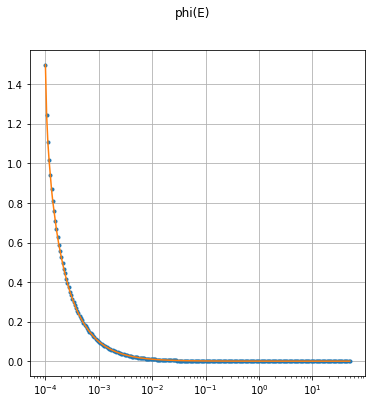

$\phi(E)$ points:  250


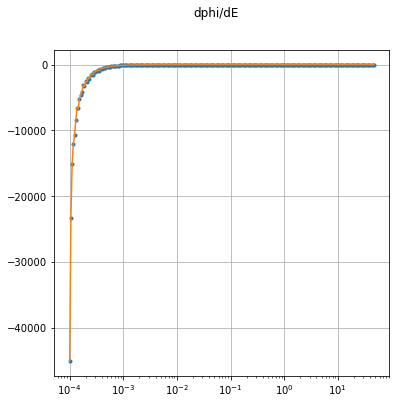

$\frac{d\phi}{dE}$ points:  249


In [18]:
phiEInterp = interpolate.interp1d(masterDF.E,masterDF.Beta2) # the function phi(E)
EPhiInterp = interpolate.interp1d(masterDF.Beta2,masterDF.E) # The function E(phi)

phiEDer = []
for e in masterDF.E[:-1]:
    phiEDer.append(derivative(phiEInterp,e,h = masterDF. E[3]-masterDF.E[2],method = 'forward'))

    
dPhidEInterp = interpolate.interp1d(masterDF.E[:-1],phiEDer)
    
# print (masterDF.E)
# print (masterDF.E[:-1])
    
figDeriv = plt.figure(figsize = (6,6))
plt.plot(masterDF.E,masterDF.Beta2,'.', color = 'C0', label = 'phi(E)')
plt.plot(masterDF.E,phiEInterp(masterDF.E),color = 'C1')
plt.suptitle('phi(E)')
plt.xscale('log')
plt.yscale('linear')
plt.grid()
plt.show()
print (r'$\phi(E)$ points: ', len(masterDF.Beta2))

figDeriv = plt.figure(figsize = (6,6))
plt.plot(masterDF.E[:-1],phiEDer,'.', label = 'dphi/dE',color = 'C0')
plt.plot(masterDF.E[:-1],dPhidEInterp(masterDF.E[:-1]),color = 'C1')
plt.suptitle('dphi/dE')
plt.xscale('log')
plt.yscale('linear')
plt.grid()
plt.show()
print (r'$\frac{d\phi}{dE}$ points: ', len(phiEDer))



In [105]:
print (dPhidEInterp(0.000845))
print (dPhidEInterp(35.878490))

-144.07200656006552
-7.206659730000954e-08


# Domain checks

Here we plot all spectra, phi(E) and dphidE(E) on the same plot to ensure that dphide has support overall spectra.


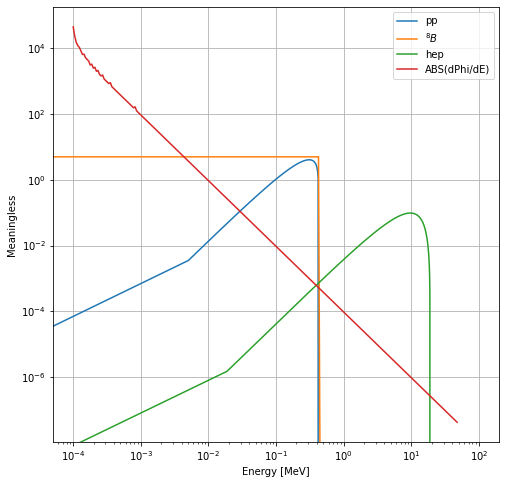

In [45]:
figB = plt.figure(figsize = (8,8))
plt.plot(ppE,np.multiply(ppS,ppFF),label = 'pp')
plt.plot(b8E,np.multiply(b8S,b8FF),label = '$^8B$')
plt.plot(hepE,np.multiply(hepS,hepFF),label = 'hep')
# plt.plot(masterDF.E,phiEInterp(masterDF.E), label = 'phi(E)')
plt.plot(masterDF.E[:-1],np.abs(dPhidEInterp(masterDF.E[:-1])),label = 'ABS(dPhi/dE)')
plt.legend(loc = 'upper right')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy [MeV]')
plt.ylabel('Meaningless')
plt.grid()
plt.show()

# Convolving $\frac{dN}{dE} \times \frac{dE}{d\phi}$

The crux of the problem lies in adjusting the bin sizing dynamically between the neutrino spectrum $\frac{dN}{dE}$, binned in constant $E$, and the phi distribution $\frac{d\phi}{dE}$, also binned in constant $E$.

We ultimately want the number of neutrinos for a given range of deflection angles, binned in constant $\phi$. We can calculate this for each bin as follows:

$$\Delta N_\phi = \frac{\Delta N_E}{\Delta E} \ \frac{dE}{d\phi}|_{Bin} \ \Delta \phi$$ with $\Delta \phi$ a constant spacing between bins in $\phi$.


- $\Delta N_\phi$: the number of neutrinos in a bin of constant $\phi$
- $\Delta N_E$: the number of neutrinos in a bin of constant $E$
- $\Delta E$: the difference between $E_i$ and $E_{i+1}$
- $\frac{dE}{d\phi}|_{Bin}$: the absolute value of the derivative of $\phi(E)$ evaluated at "bin $E_i$"
- $\Delta \phi$: the difference between $\phi(E_i)$ and $\phi(E_{i+1})$


#### Hide this


In [8]:
nBins = 20
deltaPhi = (np.pi/2) * (1/nBins)


def convolution(spectrumDF, density = True):
    '''
    This function re-scales the bins in the spectrum (dN/dE) from constant E to bins of constant phi.
    For each bin, compute the following quantity
        
        dN/dPhi = dN/dE x (deltaPhi / deltaE) x (1/ dPhi/dE)
    
    spectrumDF: Dataframe with columns containing: q_MeV (Energy values), Spectra (dN/dE), step_MeV
                q_MeV is assumed to be evenly spaced and Spectra is assumed to be L1 normalized.  
    '''
    deltaE = spectrumDF.step_MeV[0]
    fluxFactor = 1

    
    if not density:
        fluxFactor = spectrumDF.total_flux[0]
    probVector = []
    for i in range(0,len(spectrumDF)-1):
        ei = spectrumDF.q_MeV[i]
        eiplus1 = spectrumDF.q_MeV[i+1]
        probi = fluxFactor * spectrumDF.spectrum[i]
#         deltaPhi = np.abs(phiInterp(eiplus1) - phiInterp(ei))
        newProb = probi * (1/np.abs(phiEDerInterp(ei))) * (np.abs(deltaPhi)/deltaE)
        print ('loop {0}: ', i)
        print ('deltaE: ', deltaE)
        print ('ei: ', ei)
        print ('probi: ', probi)
        print ('deltaPhi: ',deltaPhi)
        print ('ABSphiEDer: ', phiEDerInterp(ei))
        print ('newProb: ',newProb)
        print ('---------------')
        probVector.append(newProb)
    return probVector

def convolution2(spectrumDF, deltaPhi, density = True):
    '''
    This function re-scales the bins in the spectrum (dN/dE) from constant E to bins of constant phi.
    For each bin, compute the following quantity
        
        dN/dPhi = dN/dE x (deltaPhi / deltaE) x (1/ dPhi/dE)
    
    spectrumDF: Dataframe with columns containing: q_MeV (Energy values), Spectra (dN/dE), step_MeV
                q_MeV is assumed to be evenly spaced and Spectra is assumed to be L1 normalized.  
    '''
    deltaE = spectrumDF.step_MeV[0]
    fluxFactor = 1
    
    def testDer(x):
        return -1/2
    
    def ePhi(x):
        return -1/2 * x
    
    if not density:
        fluxFactor = spectrumDF.total_flux[0]
    probVector = []
    for i in range(0,len(spectrumDF)-1):
        
        
        ei = spectrumDF.q_MeV[i]
        eiplus1 = spectrumDF.q_MeV[i+1]
        probi = fluxFactor * spectrumDF.spectrum[i]
#         deltaPhiPrime = np.abs(phiInterp(eiplus1) - phiInterp(ei))
        deltaPhiPrime = np.abs(testDer(eiplus1) - testDer(ei))

        newProb = probi * (1/np.abs(phiEDerInterp(ei))) * (deltaPhiPrime/deltaPhi)
        probVector.append(newProb)
    return probVector

histData  = (convolution(ppSpectra,density = True))
histData2 =  (convolution2(ppSpectra,deltaPhi, density = True))
print (len(histData))





# print (np.multiply(histData1,ppFF))

loop {0}:  0
deltaE:  0.00504
ei:  0.00504
probi:  0.0035
deltaPhi:  0.07853981633974483
ABSphiEDer:  -29.933724251267826
newProb:  0.0018220766205699485
---------------
loop {0}:  1
deltaE:  0.00504
ei:  0.01008
probi:  0.0138
deltaPhi:  0.07853981633974483
ABSphiEDer:  -7.408628100320194
newProb:  0.029026898665818524
---------------
loop {0}:  2
deltaE:  0.00504
ei:  0.015119999999999998
probi:  0.0307
deltaPhi:  0.07853981633974483
ABSphiEDer:  -3.2901612127982545
newProb:  0.14540540224844442
---------------
loop {0}:  3
deltaE:  0.00504
ei:  0.02016
probi:  0.0538
deltaPhi:  0.07853981633974483
ABSphiEDer:  -1.8521137748178813
newProb:  0.4526619175517058
---------------
loop {0}:  4
deltaE:  0.00504
ei:  0.0252
probi:  0.083
deltaPhi:  0.07853981633974483
ABSphiEDer:  -1.1846312467139661
newProb:  1.0918280652234396
---------------
loop {0}:  5
deltaE:  0.00504
ei:  0.030239999999999996
probi:  0.1179
deltaPhi:  0.07853981633974483
ABSphiEDer:  -0.8226102215968601
newProb:  2.23

deltaPhi:  0.07853981633974483
ABSphiEDer:  -0.012337936109836608
newProb:  4622.5971499813395
---------------
loop {0}:  49
deltaE:  0.00504
ei:  0.25203000000000003
probi:  3.7194
deltaPhi:  0.07853981633974483
ABSphiEDer:  -0.011829390857392229
newProb:  4899.704064380019
---------------
loop {0}:  50
deltaE:  0.00504
ei:  0.25706999999999997
probi:  3.7749
deltaPhi:  0.07853981633974483
ABSphiEDer:  -0.011390245489359085
newProb:  5164.540790241154
---------------
loop {0}:  51
deltaE:  0.00504
ei:  0.26211
probi:  3.8262
deltaPhi:  0.07853981633974483
ABSphiEDer:  -0.01095110012132593
newProb:  5444.6411694423505
---------------
loop {0}:  52
deltaE:  0.00504
ei:  0.26715
probi:  3.8731
deltaPhi:  0.07853981633974483
ABSphiEDer:  -0.01053513235653917
newProb:  5728.989931300299
---------------
loop {0}:  53
deltaE:  0.00504
ei:  0.27219
probi:  3.9154
deltaPhi:  0.07853981633974483
ABSphiEDer:  -0.010160823138285731
newProb:  6004.911198994519
---------------
loop {0}:  54
deltaE:

In [9]:

spectrum = [0,10,0,0,0]
eSpacing = [0,1,2,3,4]
spectrumInterp = interpolate.interp1d(eSpacing,spectrum)
# spectrumHist = np.histogram(spectrum, bins=4)
hist_dist = scipy.stats.rv_histogram(spectrumHist)

def testEPhi(x):
    return -4*x

def testdEdPhi(x):
    return -4

deltaPhi = 1
phiMax = 4
nPhiBins = int(np.floor((phiMax) * (1/deltaPhi)))
print ('nPhiBins: ',nPhiBins)
phiBinsArray = np.linspace(testEPhi(min(eSpacing)),phiMax,nPhiBins+1)
print ('phibins: ',phiBinsArray)

eBinsArray   = np.abs(testEPhi(phiBinsArray))
print ('eBins: ',eBinsArray)

dEdPhiArray  = testdEdPhi(eBinsArray)
print ('dEdPhiBins: ', dEdPhiArray)

eventArray   = spectrumInterp(eBinsArray)

print ('eventArray: ', eventArray)

plt.plot(eSpacing,spectrumInterp(eSpacing),label= 'spectrum')
plt.grid()
for value in eBinsArray:
    plt.axvline(x = value, color = 'C1',label = 'eBins')
plt.legend(loc = 'upper right')


newCounts = []
for i in range(0,nPhiBins):
    deltaE = eBinsArray[i]-eBinsArray[i+1]
    tempCounts = (eventArray[i]/(deltaE)) * dEdPhiArray[i] * deltaPhi
    newCounts.append(tempCounts)
    
# newSpectrumHist = np.histogram(newCounts, bins=nPhiBins)
# newHist_dist = scipy.stats.rv_histogram(newSpectrumHist)
print ('NewCounts: ', newCounts)
# plt.plot(phiBinsArray[:-1],newCounts,color = 'C2')

NameError: name 'scipy' is not defined

### Working Here

The dNdE spectra have the same shapes (roughly the same slope in log-log space, and a similar turnover rate after the apex). This determines the shape of the dNdphi spectrum. The higher energy spectra yield a smaller deflection angle, hence the lower values for their dNdphi spectra.

14 bins
14 bins


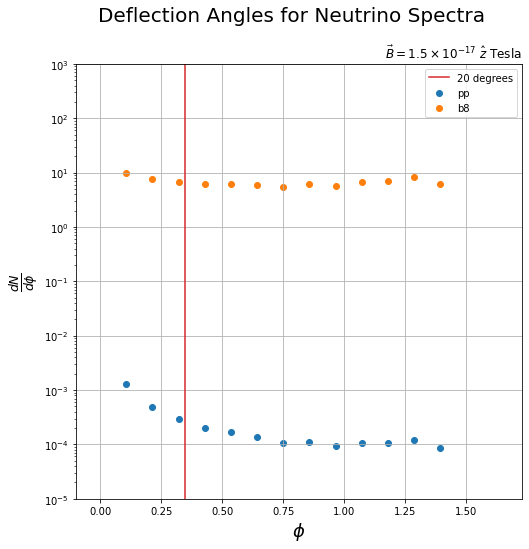

In [51]:
def convolution(spectrumDF,deltaPhi,density = False):
    '''
    spectrumDF: The neutrino energy spectrum dataframe containing columns labeled
                "q_MeV", "spectrum","step_MeV", "total_flux"
    deltaPhi  : the phi bin width in radians
    density   : If True, the returned dN/dphi spectrum will L1-normed
    
    returns:
        phiBinLims: An array containing the bin limits for phi
        newCountsArray: The unnormalized weights of dN/dPhi in each bin.
        
    '''
    spectrum = spectrumDF.spectrum
    spectrumInterp = interpolate.interp1d(spectrumDF.q_MeV,spectrum)
#     print (spectrum)
#     phiMax = phiEInterp(interpEMIN+0.0001*interpEMIN)
#     phiMin = phiEInterp(interpEMAX-0.0001*interpEMAX)

    phiMax = phiEInterp(masterDF.E.iloc[0])
    phiMin = phiEInterp(masterDF.E.iloc[-2]) # The phi(E) interpolation is defined up to the last
                                             # energy, but the dPhi/dE interpolation has support up
                                             # up to the second to last energy point
                                             # (because of the forward derivative)
#     print ('phiMax:', phiMax)
#     print ('phiMin:', phiMin)
    
    nPhiBins = int(np.floor((phiMax * (1/deltaPhi))))
    print (nPhiBins,'bins')
#     print ('nPhiBins:',nPhiBins)
    
    phiBinLims = np.linspace(phiMin,phiMax,nPhiBins+1)
#     print ('phiBinLims:',phiBinLims)

    eBinLims = EPhiInterp(phiBinLims)
#     print ('eBinLims:',eBinLims)
    
    dPhidELims = dPhidEInterp(eBinLims)
#     print ('dPhidELims:',dPhidELims)
    
    eventArray = spectrumInterp(eBinLims) 
#     print ('eventArray:',eventArray)
    
    newCountsArray = []
    for i in range(0,nPhiBins):
        deltaEi = eBinLims[i] - eBinLims[i+1]
        adjustedCounts = (eventArray[i]/np.abs(deltaEi)) * np.abs(1/dPhidELims[i]) * deltaPhi
        newCountsArray.append(adjustedCounts)
    if density:
        newCountsArray  = (L1Norm(newCountsArray,deltaPhi))
    
    return phiBinLims.flatten(),newCountsArray
    
deltaPhi = 0.1
# deltaPhi = 0.16
# deltaPhi = 0.25
newppCounts = (convolution(ppSpectra,deltaPhi,False))
# newhepCounts = (convolution(hepSpectra,deltaPhi,False))
newb8Counts = (convolution(b8Spectra,deltaPhi,False))


moneyFig = plt.figure(figsize = (8,8))
plt.scatter(newppCounts[0][:-1],newppCounts[1], label = 'pp')
# plt.scatter(newhepCounts[0][:-1],newhepCounts[1], label = 'hep')
plt.scatter(newb8Counts[0][:-1],newb8Counts[1], label = 'b8')
plt.axvline(x = 20*np.pi/180,color = 'C3',label = '20 degrees')
plt.legend(loc = 'upper right')
plt.suptitle('Deflection Angles for Neutrino Spectra',size = 20)
plt.title(r'$\vec{B} = 1.5\times 10^{-17} \ \hat{z}$ Tesla', loc = 'right')
plt.ylabel(r'$\frac{dN}{d\phi}$',size = 18)
plt.xlabel(r'$\phi$', size = 18)
plt.yscale('log')
plt.xscale('linear')
# plt.axis([-0.1,np.pi/2+(0.1*np.pi/2),10**-8.5,10**-2.5])
plt.axis([-0.1,np.pi/2+(0.1*np.pi/2),10**-5,10**3])

plt.grid()
plt.show()


# plt.hist(newppCounts[0][:-1],bins = newppCounts[0], weights = newppCounts[1])
# plt.hist(newhepCounts[0][:-1],bins = newhepCounts[0], weights = newhepCounts[1])
# plt.show()
# plt.hist(newppCounts[0][:-1],bins = newppCounts[0][:-1])

## Checking the L1 normalization of the $\frac{dN}{d\phi}$ spectrum

In [53]:
def L1Norm(vector, binSpacing):
    '''
    This function normalizes a vector according to 
        Sum(vector * bin) = Normalization
    and return vector/Normalization
    
    vector: vector to be normalized
    binSpacing: constant width of each bin
    '''
    totalSum = 0
    i = 0
    for val in vector:
#         print ('val',val)
#         print ('binSpacing',binSpacing)

#         print ('val',val)
#         print ('binSpacing',binSpacing)
        totalSum += val*binSpacing
    normedVector = np.multiply(vector,(1/totalSum))
    return normedVector

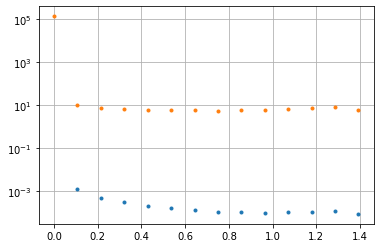

In [66]:
plt.plot(newppCounts[0][:-1],newppCounts[1],'.')
plt.plot(newb8Counts[0][:-1],np.multiply(newb8Counts[1],1),'.')
plt.yscale('log')
plt.grid()

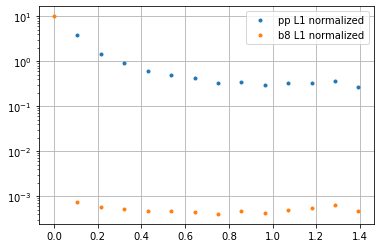

In [68]:
l1Normedpp  = (L1Norm(newppCounts[1],deltaPhi))
l1Normedhep = (L1Norm(newhepCounts[1],deltaPhi))
l1Normedb8  = (L1Norm(newb8Counts[1],deltaPhi))

# print (l1Normedpp)
# print (l1Normedhep)
# print (l1Normedb8)

# print (l1Normedpp)
# print (l1Normedhep)

# plt.plot(newppCounts[0][:-1],newppCounts[1],'.',label = 'L1 normalized')
# plt.plot(newhepCounts[0][:-1],newhepCounts[1],'.',label = 'L1 normalized')
# plt.plot(newb8Counts[0][:-1],newb8Counts[1],'.',label = 'L1 normalized')

plt.plot(newppCounts[0][:-1],l1Normedpp,'.',label = 'pp L1 normalized')
# plt.plot(newhepCounts[0][:-1],l1Normedhep,'.',label = 'hep L1 normalized')
plt.plot(newb8Counts[0][:-1],l1Normedb8,'.',label = 'b8 L1 normalized')

plt.legend(loc = 'upper right')
plt.yscale('log')
plt.grid()

# Junk that is probably wrong

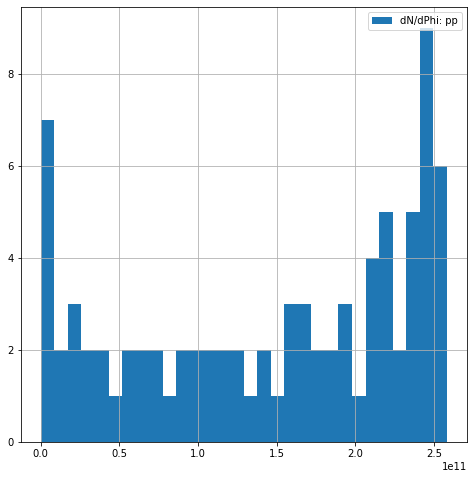

In [73]:
ppSpacing  = ppSpectra.step_MeV[0]
b8Spacing  = b8Spectra.step_MeV[0]
hepSpacing = hepSpectra.step_MeV[0]


ppPhiSpectra = (convolution(ppSpectra, density = False))
b8PhiSpectra = (convolution(b8Spectra,density = False))
hepPhiSpectra = (convolution(hepSpectra,density = False))

ppPhiSpectraNormed = L1Norm(ppPhiSpectra,(np.pi/2 / len(ppSpectra)))
figbig = plt.figure(figsize = (8,8))
plt.hist(ppPhiSpectra, bins = 30, density = False, label = 'dN/dPhi: pp')
# plt.hist(b8PhiSpectra, bins = 30, density = False, label = 'dN/dPhi: b8')
# plt.hist(hepPhiSpectra,bins = 30, density = False, label = 'dN/dPhi: hep')
         
# plt.hist(ppPhiSpectraNormed, bins = len(ppS),density = True, label = 'dN/dPhi Normed')

plt.legend(loc = 'upper right')
plt.grid()
plt.show()
# plt.xscale('log')
# plt.yscale('log')



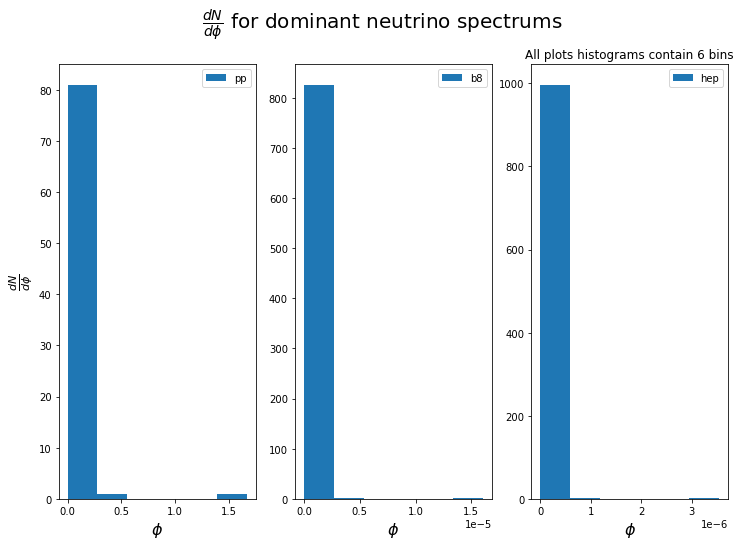

In [28]:
nBins = 6

fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize = (12,8))
fig.suptitle(r'$\frac{dN}{d\phi}$ for dominant neutrino spectrums', size = 20)
plt.title('All plots histograms contain {0} bins'.format(nBins))
ax1.hist(ppPhiSpectra,bins = nBins, density = False, label = 'pp')
ax1.set_xlabel(r'$\phi$', size = 16)
ax1.set_ylabel(r'$\frac{dN}{d\phi}$', size = 16)
ax1.legend(loc = 'upper right')
ax2.hist(b8PhiSpectra,bins = nBins, density = False, label = 'b8')
ax2.set_xlabel(r'$\phi$', size = 16)
ax2.legend(loc = 'upper right')
ax3.hist(hepPhiSpectra,bins = nBins, density = False, label = 'hep')
ax3.set_xlabel(r'$\phi$', size = 16)
ax3.legend(loc = 'upper right')
plt.show()
